Loading previously saved basis motif results from saved_results...
Results loaded successfully!

CONNECTING BASIS MOTIFS TO ENERGY LANDSCAPE TOPOLOGY FOR TCOA

MAPPING BASIS MOTIFS TO ENERGY LANDSCAPE
Calculating energy profiles for basis motifs...
Calculating energy profiles for ALL motifs (not just basis motifs)...
Preparing features for dimensionality reduction...
Applying UMAP for dimensionality reduction on ALL motifs...
Candidate factor 0.5: avg neighbors = 0.91
Candidate factor 0.75: avg neighbors = 2.91
Candidate factor 1.0: avg neighbors = 4.97
Candidate factor 1.25: avg neighbors = 7.03
Candidate factor 1.5: avg neighbors = 9.09
Candidate factor 2.0: avg neighbors = 12.57
Chosen adaptive radius factor: 1.5
Adaptive radius: 1.0900
Found 1 local minima, 2 local maxima, 0 saddle points, and 30 transition regions.
Global minimum at index 31, global maximum at index 26
Analyzing topological significance of basis motifs...

Basis Motif Topological Roles:
Basis Motif 3: Transition R

/home/cerna3/anaconda3/envs/hmm_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Saved 2D energy landscape plot to: energy_landscape_results/energy_landscape_2d.png


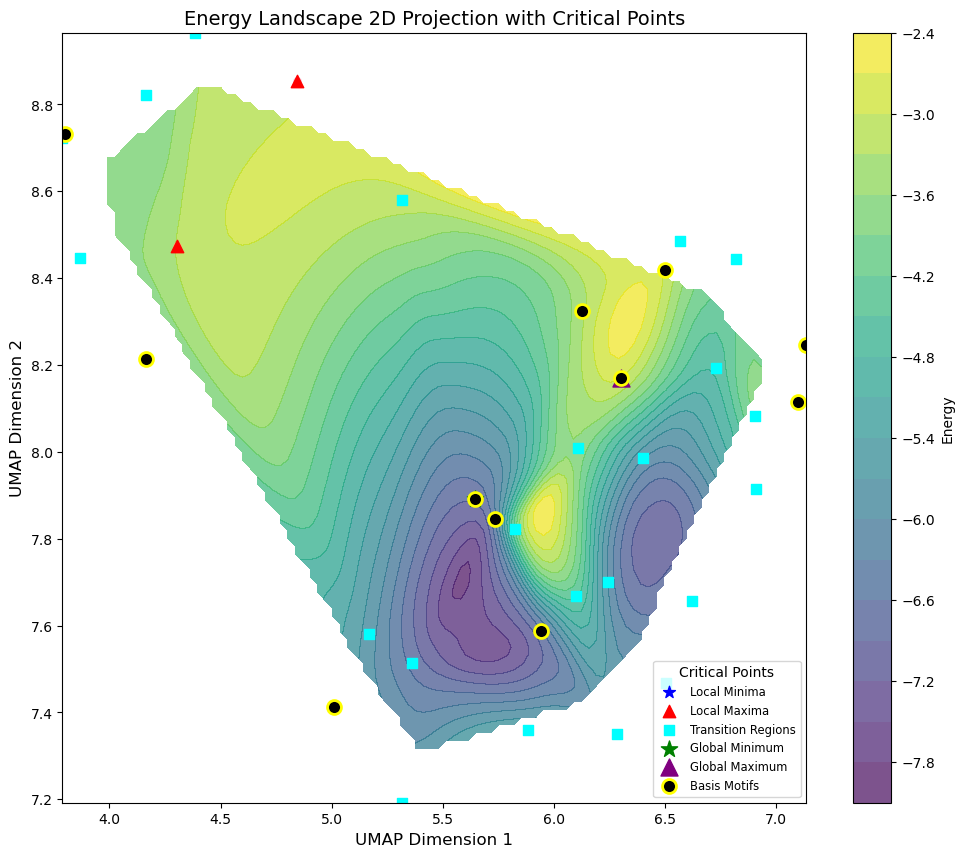

Plotting 3D energy landscape...
Saved 3D energy landscape plot to: energy_landscape_results/energy_landscape_3d.png


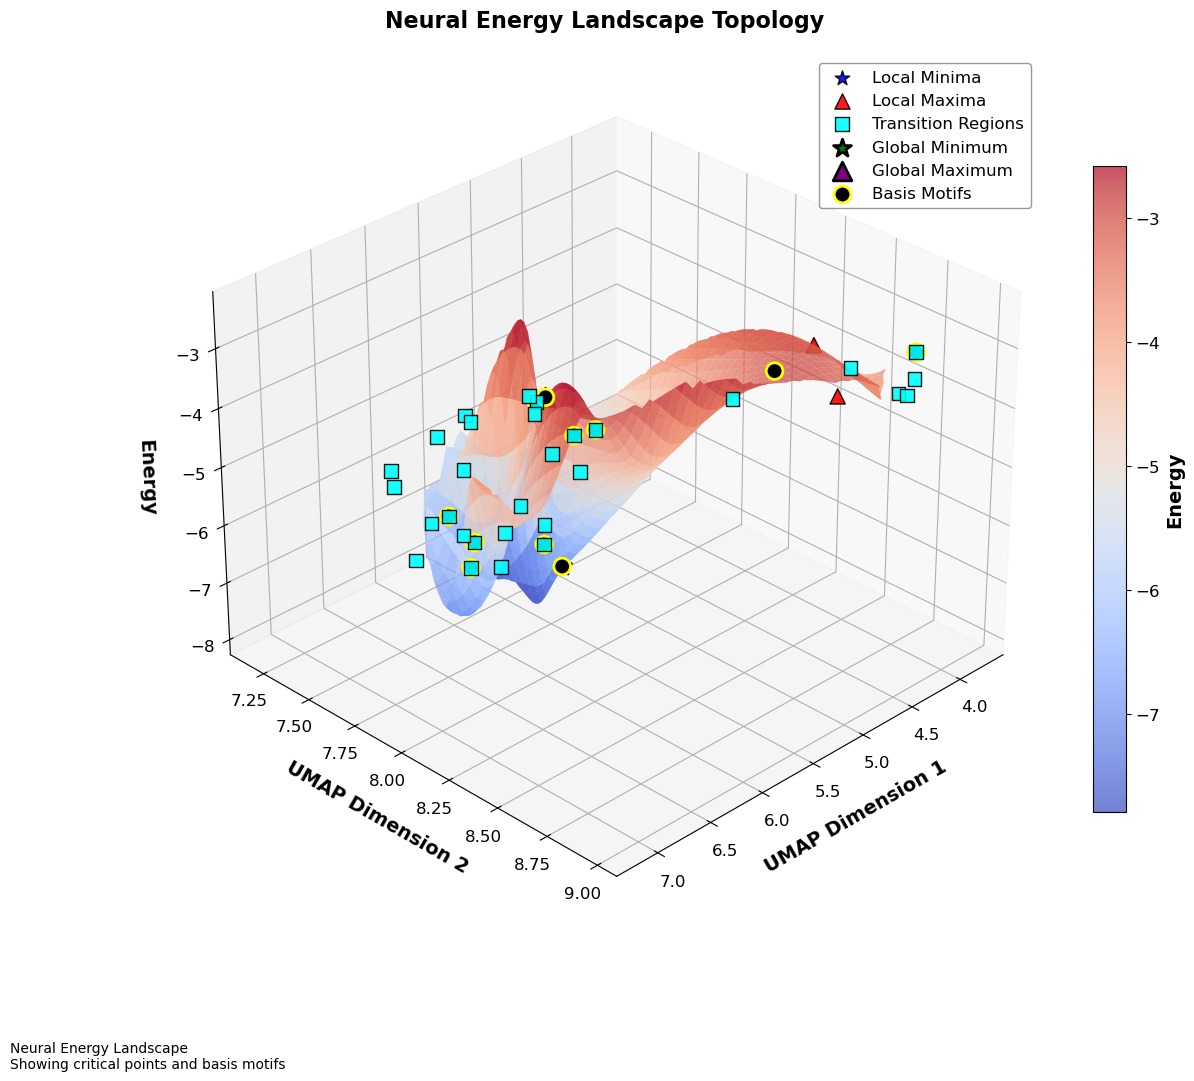

Creating interactive 3D energy landscape visualization...
Interactive visualization saved to: energy_landscape_results/interactive_energy_landscape.html

Extracting data for TCOA participants...
Found 12 unique TCOA participants
TCOA participant IDs: ['401', '403', '404', '406', '408', '409', '410', '411', '412', '413', '415', '416']
Loading practice hours from: /home/cerna3/neuroconn/Datasets_and_raw_data/Participant Experience - TCOA 401-416.xlsx
Data shape: (15, 3)
Data columns: ['ID', 'Experience', 'Notes ']
First few rows:
    ID  Experience             Notes 
0  401        4680           4680 hrs
1  402        1560            1560hrs
2  403         858        780-936 hrs
3  404        1560  3hrs/wk *10 years
4  406        1664           1664 hrs
Loaded: 401 -> 4680.0 hours
Loaded: 402 -> 1560.0 hours
Loaded: 403 -> 858.0 hours
Loaded: 404 -> 1560.0 hours
Loaded: 406 -> 1664.0 hours
Loaded: 407 -> 2496.0 hours
Loaded: 408 -> 1040.0 hours
Loaded: 409 -> 1716.0 hours
Loaded: 410 -> 

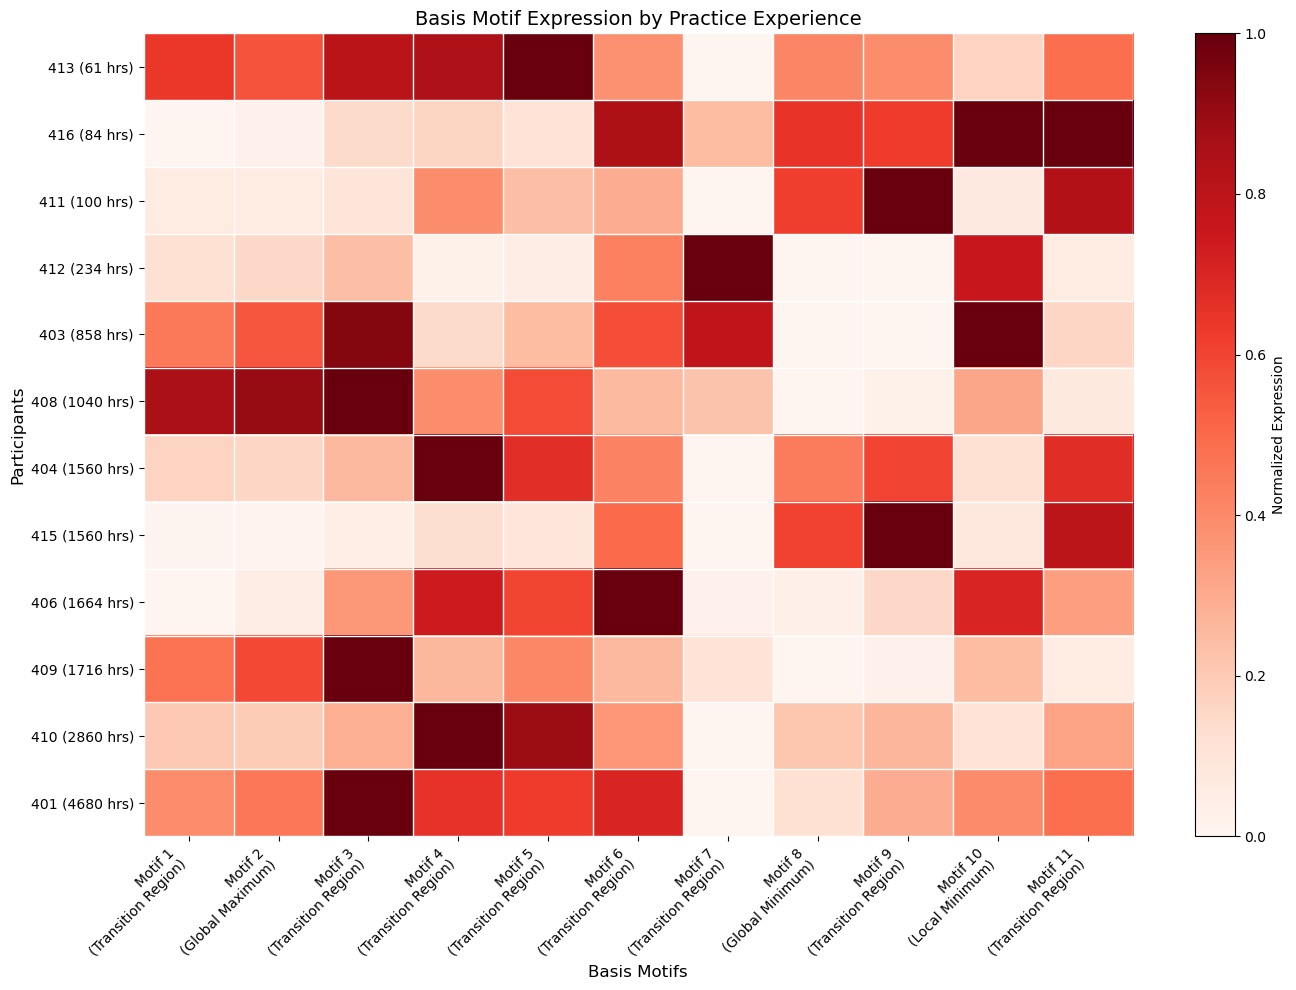

Trajectory data saved to energy_landscape_results/trajectory_data.pkl

TCOA ENERGY LANDSCAPE TOPOLOGY SUMMARY
Identified 11 basis motifs representing distinct functional connectivity patterns
Results saved to: energy_landscape_results


In [5]:
# Energy Landscape Analysis: Motif Topology Detection and Visualization(s) 

import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import griddata
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
import pandas as pd

# =============================================================================
# Loading Functions
# =============================================================================

def load_basis_motif_results(save_dir="saved_results"):
    """
    Load previously saved basis motif results.
    """
    basis_motif_path = os.path.join(save_dir, "basis_motif_results.pkl")
    indicator_path = os.path.join(save_dir, "save_complete.txt")
    
    if os.path.exists(basis_motif_path) and os.path.exists(indicator_path):
        print(f"Loading previously saved basis motif results from {save_dir}...")
        with open(basis_motif_path, "rb") as f:
            basis_motif_results = pickle.load(f)
        print("Results loaded successfully!")
        return basis_motif_results
    else:
        print("No saved basis motif results found. Please run the earlier analysis or check the save path.")
        return None

# =============================================================================
# Energy Landscape Representation Functions
# =============================================================================

def calculate_boltzmann_energy(connectivity, temperature=1.0):
    normalized = np.abs(connectivity) / (1 + np.abs(connectivity))
    energy = -temperature * np.log(normalized + 1e-10)
    return energy

def calculate_motif_energy(motif_matrices, temperature=1.0):
    matrix_energies = []
    total_energies = []
    network_energies = []
    for matrix in motif_matrices:
        triu_indices = np.triu_indices_from(matrix, k=1)
        connectivity_values = matrix[triu_indices]
        energy_values = calculate_boltzmann_energy(connectivity_values, temperature)
        energy_matrix = np.zeros_like(matrix)
        energy_matrix[triu_indices] = energy_values
        energy_matrix = energy_matrix + energy_matrix.T
        matrix_energies.append(energy_matrix)
        total_energies.append(np.sum(energy_values))
        n_regions = matrix.shape[0]
        avg_network_energy = np.zeros(n_regions)
        for i in range(n_regions):
            connections = np.concatenate([matrix[i, :i], matrix[i, i+1:]])
            energies = calculate_boltzmann_energy(connections, temperature)
            avg_network_energy[i] = np.mean(energies)
        network_energies.append(avg_network_energy)
    energy_stats = {
        'matrix_energies': matrix_energies,
        'total_energies': total_energies,
        'network_energies': network_energies,
        'mean_energy': np.mean(total_energies),
        'energy_variance': np.var(total_energies),
        'energy_min': np.min(total_energies),
        'energy_max': np.max(total_energies),
        'energy_trajectory': np.array(total_energies)
    }
    return energy_stats

# In create_energy_landscape_representation function
def create_energy_landscape_representation(basis_results, output_dir='energy_landscape_results'):
    os.makedirs(output_dir, exist_ok=True)
    basis_motifs = basis_results['basis_motifs']
    basis_metadata = basis_results['basis_metadata']
    
    # Get ALL functional connectivity motifs - not just basis motifs
    fc_motifs = basis_results['fc_motifs']
    metadata = basis_results['metadata']
    
    print("\n" + "="*80)
    print("MAPPING BASIS MOTIFS TO ENERGY LANDSCAPE")
    print("="*80)
    
    print("Calculating energy profiles for basis motifs...")
    basis_motif_energies = {}
    for cluster_label, motif_matrices in basis_motifs.items():
        energy_stats = calculate_motif_energy(motif_matrices)
        basis_motif_energies[cluster_label] = energy_stats

    print("Calculating energy profiles for ALL motifs (not just basis motifs)...")
    all_motif_energies = []
    for motif_matrices in fc_motifs:
        energy_stats = calculate_motif_energy(motif_matrices)
        all_motif_energies.append(energy_stats)

    print("Preparing features for dimensionality reduction...")
    energy_features = []
    for energy_stats in all_motif_energies:
        features = [
            energy_stats['mean_energy'],
            energy_stats['energy_variance'],
            energy_stats['energy_min'],
            energy_stats['energy_max']
        ]
        trajectory = energy_stats['energy_trajectory']
        trajectory_length = min(10, len(trajectory))
        trajectory_padded = np.zeros(10)
        trajectory_padded[:trajectory_length] = trajectory[:trajectory_length]
        features.extend(trajectory_padded)
        energy_features.append(features)
    
    # Ensure we're using ALL motifs here, not just basis motifs
    scaler = StandardScaler()
    energy_features_scaled = scaler.fit_transform(energy_features)
    
    print("Applying UMAP for dimensionality reduction on ALL motifs...")
    import umap
    reducer = umap.UMAP(n_components=3, random_state=42, min_dist=0.1, n_neighbors=15)
    umap_embedding = reducer.fit_transform(energy_features_scaled)
    
    x = umap_embedding[:, 0]
    y = umap_embedding[:, 1]
    z = umap_embedding[:, 2]
    
    grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]
    grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')
    grid_z = gaussian_filter(grid_z, sigma=1.0)
    
    landscape_results = {
        'basis_motif_energies': basis_motif_energies,
        'all_motif_energies': all_motif_energies,
        'energy_features': energy_features,
        'energy_features_scaled': energy_features_scaled,
        'umap_embedding': umap_embedding,  # This now contains ALL motifs
        'umap_model': reducer,
        'grid_x': grid_x,
        'grid_y': grid_y,
        'grid_z': grid_z,
        'output_dir': output_dir,
        'basis_motifs': basis_motifs,
        'basis_metadata': basis_metadata,
        'metadata': metadata
    }
    return landscape_results

# =============================================================================
# Adaptive Neighborhood & Hessian-Based Critical Point Detection
# =============================================================================

def compute_mahalanobis_distance(point, other, inv_cov):
    diff = point - other
    return np.sqrt(np.dot(np.dot(diff.T, inv_cov), diff))

def choose_adaptive_radius_factor(umap_coords, inv_cov, candidate_factors=[0.5, 0.75, 1.0, 1.25, 1.5, 2.0],
                                  desired_range=(5,15), fixed_neighbors=10):
    n = umap_coords.shape[0]
    medians = []
    dist_mat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist_mat[i,j] = compute_mahalanobis_distance(umap_coords[i], umap_coords[j], inv_cov)
    for i in range(n):
        sorted_dists = np.sort(dist_mat[i])[1:fixed_neighbors+1]
        medians.append(np.median(sorted_dists))
    medians = np.array(medians)
    global_med = np.median(medians)
    best_factor = candidate_factors[0]
    best_diff = np.inf
    for factor in candidate_factors:
        radius = factor * global_med
        counts = [np.sum(dist_mat[i] < radius) - 1 for i in range(n)]
        avg_neighbors = np.mean(counts)
        midpoint = np.mean(desired_range)
        diff = abs(avg_neighbors - midpoint)
        print(f"Candidate factor {factor}: avg neighbors = {avg_neighbors:.2f}")
        if diff < best_diff:
            best_diff = diff
            best_factor = factor
    print(f"Chosen adaptive radius factor: {best_factor}")
    return best_factor, global_med

def compute_hessian_at_point(x, y, grid_x, grid_y, grid_z):
    x_vals = grid_x[0, :]
    y_vals = grid_y[:, 0]
    i = np.argmin(np.abs(x_vals - x))
    j = np.argmin(np.abs(y_vals - y))
    if i==0 or i==len(x_vals)-1 or j==0 or j==len(y_vals)-1:
        return np.array([[0,0],[0,0]])
    dx = x_vals[1]-x_vals[0]
    dy = y_vals[1]-y_vals[0]
    f_xx = (grid_z[j, i+1] - 2*grid_z[j, i] + grid_z[j, i-1]) / (dx**2)
    f_yy = (grid_z[j+1, i] - 2*grid_z[j, i] + grid_z[j-1, i]) / (dy**2)
    f_xy = (grid_z[j+1, i+1] - grid_z[j+1, i-1] - grid_z[j-1, i+1] + grid_z[j-1, i-1]) / (4*dx*dy)
    return np.array([[f_xx, f_xy],[f_xy, f_yy]])

def find_critical_points(landscape_results, fixed_neighbors=10, candidate_factors=[0.5,0.75,1.0,1.25,1.5,2.0],
                          desired_range=(5,15), hessian_thresh=1e-3):
    umap_embedding = landscape_results['umap_embedding']
    coords = umap_embedding[:, :2]
    energies = umap_embedding[:, 2]  # Using third dimension as energy
    cov = np.cov(coords.T)
    inv_cov = np.linalg.inv(cov)
    factor, global_med = choose_adaptive_radius_factor(coords, inv_cov, candidate_factors, desired_range, fixed_neighbors)
    adaptive_radius = factor * global_med
    print(f"Adaptive radius: {adaptive_radius:.4f}")
    n = coords.shape[0]
    dist_mat = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist_mat[i,j] = compute_mahalanobis_distance(coords[i], coords[j], inv_cov)
    local_minima = []
    local_maxima = []
    saddle_points = []
    transition_regions = []
    grid_x = landscape_results['grid_x']
    grid_y = landscape_results['grid_y']
    grid_z = landscape_results['grid_z']
    for i in range(n):
        neighbors = np.where((dist_mat[i] < adaptive_radius) & (np.arange(n) != i))[0]
        if len(neighbors) == 0:
            continue
        energy_i = energies[i]
        neighbor_energies = energies[neighbors]
        if np.all(energy_i <= neighbor_energies):
            local_minima.append(i)
        elif np.all(energy_i >= neighbor_energies):
            local_maxima.append(i)
        else:
            x_i, y_i = coords[i]
            H = compute_hessian_at_point(x_i, y_i, grid_x, grid_y, grid_z)
            eigvals = np.linalg.eigvals(H)
            if np.all(eigvals > hessian_thresh):
                local_minima.append(i)
            elif np.all(eigvals < -hessian_thresh):
                local_maxima.append(i)
            elif eigvals[0] * eigvals[1] < 0:
                saddle_points.append(i)
            else:
                transition_regions.append(i)
    
    # Always assign global min/max from the full energy vector
    global_minimum = np.argmin(energies)
    global_maximum = np.argmax(energies)
    
    # Remove global extrema from local lists to avoid confusion
    if global_minimum in local_minima:
        local_minima.remove(global_minimum)
    if global_maximum in local_maxima:
        local_maxima.remove(global_maximum)
    
    print(f"Found {len(local_minima)} local minima, {len(local_maxima)} local maxima, {len(saddle_points)} saddle points, and {len(transition_regions)} transition regions.")
    print(f"Global minimum at index {global_minimum}, global maximum at index {global_maximum}")
    
    landscape_results.update({
        'local_minima': local_minima,
        'local_maxima': local_maxima,
        'saddle_points': saddle_points,
        'transition_regions': transition_regions,
        'global_minimum': global_minimum,
        'global_maximum': global_maximum,
        'adaptive_radius_factor': factor,
        'adaptive_radius': adaptive_radius
    })
    return landscape_results

# =============================================================================
# Basis Motif Topological Analysis Functions
# =============================================================================

def analyze_basis_motif_topology(landscape_results, proximity_threshold=0.3):
    """
    Analyze the topological significance of each basis motif with improved proximity detection.
    """
    print("Analyzing topological significance of basis motifs...")
    
    # Extract data
    embedding = landscape_results['umap_embedding']
    basis_metadata = landscape_results.get('basis_metadata', {})
    local_minima = landscape_results.get('local_minima', [])
    local_maxima = landscape_results.get('local_maxima', [])
    saddle_points = landscape_results.get('saddle_points', [])
    transition_regions = landscape_results.get('transition_regions', [])
    global_minimum = landscape_results.get('global_minimum')
    global_maximum = landscape_results.get('global_maximum')
    
    # Get basis motif indices
    basis_indices = []
    cluster_labels = []
    for cluster, meta in basis_metadata.items():
        if 'centroid_idx' in meta:
            basis_indices.append(meta['centroid_idx'])
            cluster_labels.append(cluster)
        else:
            print(f"Warning: Missing centroid_idx for cluster {cluster}")
    
    # Initialize topological metrics
    topological_metrics = {}
    
    # Analyze each basis motif
    for idx, (cluster, basis_idx) in enumerate(zip(cluster_labels, basis_indices)):
        # Determine topological role based on critical points
        topo_role = "Transition Region"  # Default role
        
        # First check exact matches
        if basis_idx in local_minima:
            topo_role = "Local Minimum"
        elif basis_idx in local_maxima:
            topo_role = "Local Maximum"
        elif basis_idx in saddle_points:
            topo_role = "Saddle Point"
        elif basis_idx == global_minimum:
            topo_role = "Global Minimum"
        elif basis_idx == global_maximum:
            topo_role = "Global Maximum"
        elif basis_idx in transition_regions:
            topo_role = "Transition Region"
        else:
            # Check for proximity to critical points
            basis_point = embedding[basis_idx]
            
            # Check global extrema first (they have priority)
            if global_minimum is not None:
                dist_to_global_min = np.linalg.norm(basis_point - embedding[global_minimum])
                if dist_to_global_min < proximity_threshold:
                    topo_role = "Global Minimum"
                    continue
                    
            if global_maximum is not None:
                dist_to_global_max = np.linalg.norm(basis_point - embedding[global_maximum])
                if dist_to_global_max < proximity_threshold:
                    topo_role = "Global Maximum"
                    continue
            
            # Check local extrema
            if local_minima:
                min_dists = [np.linalg.norm(basis_point - embedding[i]) for i in local_minima]
                if min(min_dists) < proximity_threshold:
                    topo_role = "Local Minimum"
                    continue
                    
            if local_maxima:
                max_dists = [np.linalg.norm(basis_point - embedding[i]) for i in local_maxima]
                if min(max_dists) < proximity_threshold:
                    topo_role = "Local Maximum"
                    continue
                    
            if saddle_points:
                saddle_dists = [np.linalg.norm(basis_point - embedding[i]) for i in saddle_points]
                if min(saddle_dists) < proximity_threshold:
                    topo_role = "Saddle Point"
                    continue
        
        # Store metrics
        topological_metrics[cluster] = {
            'basis_idx': basis_idx,
            'topological_role': topo_role
        }
    
    # Add metrics to landscape results
    landscape_results['topological_metrics'] = topological_metrics
    
    # Print summary of topological roles
    print("\nBasis Motif Topological Roles:")
    for cluster, metrics in topological_metrics.items():
        print(f"Basis Motif {cluster+1}: {metrics['topological_role']}")
    
    return landscape_results

# =============================================================================
# Plotting Functions (2D and 3D with Legends and Single Display)
# =============================================================================

def plot_energy_landscape(landscape_results):
    """
    Plot energy landscape in both 2D and 3D.
    Delegates to specific plotting functions.
    """
    # First do 2D plotting
    landscape_results = plot_energy_landscape_2d(landscape_results)
    # Then plot TCOA landscape
    landscape_results = plot_tcoa_energy_landscape(landscape_results)
    return landscape_results

def plot_energy_landscape_2d(landscape_results):
    print("Plotting 2D energy landscape...")
    grid_x = landscape_results['grid_x']
    grid_y = landscape_results['grid_y']
    grid_z = landscape_results['grid_z']
    umap_embedding = landscape_results['umap_embedding']
    metadata = landscape_results['metadata']
    output_dir = landscape_results['output_dir']
    
    # Debug information about metadata
    print("Metadata summary:")
    state_counts = {}
    for i, meta in enumerate(metadata):
        motif = meta.get('motif', '0')
        try:
            # Handle tuple motifs differently
            if isinstance(motif, tuple) and len(motif) > 0:
                state = int(motif[0])
            else:
                state = int(str(motif)[0])
            state_counts[state] = state_counts.get(state, 0) + 1
        except (IndexError, ValueError) as e:
            print(f"Warning: Invalid motif value at index {i}: {motif} - Error: {e}")
    
    print("State counts:", state_counts)
    
    # Create cluster labels with proper tuple handling
    cluster_labels = []
    for i, meta in enumerate(metadata):
        motif = meta.get('motif', '0')
        try:
            # Handle tuple motifs differently
            if isinstance(motif, tuple) and len(motif) > 0:
                state = int(motif[0])
            else:
                state = int(str(motif)[0])
            cluster_labels.append(state)
        except (IndexError, ValueError):
            # Default to state 0 if parsing fails
            print(f"Using default state 0 for index {i} with motif: {motif}")
            cluster_labels.append(0)
    
    cluster_labels = np.array(cluster_labels)
    unique_labels = np.unique(cluster_labels)
    
    print(f"Found {len(unique_labels)} unique states: {unique_labels}")
    
    if len(unique_labels) == 0:
        print("Warning: No valid states found. Check metadata format.")
    
    cmap = plt.cm.tab20
    norm = plt.Normalize(vmin=min(unique_labels) if len(unique_labels) > 0 else 0, 
                         vmax=max(unique_labels) if len(unique_labels) > 0 else 1)
    
    fig2, ax2 = plt.subplots(figsize=(12, 10))
    contour = ax2.contourf(grid_x, grid_y, grid_z, 20, cmap='viridis', alpha=0.7)
    plt.colorbar(contour, ax=ax2, label='Energy')
    
    # Plot points by state
    for label in unique_labels:
        inds = np.where(cluster_labels == label)[0]
        if len(inds) > 0:
            ax2.scatter(umap_embedding[inds, 0], 
                        umap_embedding[inds, 1], 
                        color=cmap(norm(label)), 
                        s=30, 
                        alpha=0.5, 
                        label=f'State {label}')
        else:
            print(f"No valid points found after filtering state {label}")
    
    # Plot critical points
    if 'local_minima' in landscape_results and landscape_results['local_minima']:
        ax2.scatter(umap_embedding[landscape_results['local_minima'], 0],
                    umap_embedding[landscape_results['local_minima'], 1],
                    color='blue', s=80, marker='*', label='Local Minima')
    
    if 'local_maxima' in landscape_results and landscape_results['local_maxima']:
        ax2.scatter(umap_embedding[landscape_results['local_maxima'], 0],
                    umap_embedding[landscape_results['local_maxima'], 1],
                    color='red', s=80, marker='^', label='Local Maxima')
    
    # Add saddle points and transition regions to the plot
    if 'saddle_points' in landscape_results and landscape_results['saddle_points']:
        ax2.scatter(umap_embedding[landscape_results['saddle_points'], 0],
                    umap_embedding[landscape_results['saddle_points'], 1],
                    color='yellow', s=80, marker='d', label='Saddle Points')
                    
    if 'transition_regions' in landscape_results and landscape_results['transition_regions']:
        ax2.scatter(umap_embedding[landscape_results['transition_regions'], 0],
                    umap_embedding[landscape_results['transition_regions'], 1],
                    color='cyan', s=60, marker='s', label='Transition Regions')
    
    if 'global_minimum' in landscape_results:
        ax2.scatter(umap_embedding[landscape_results['global_minimum'], 0],
                    umap_embedding[landscape_results['global_minimum'], 1],
                    color='green', s=150, marker='*', label='Global Minimum')
    
    if 'global_maximum' in landscape_results:
        ax2.scatter(umap_embedding[landscape_results['global_maximum'], 0],
                    umap_embedding[landscape_results['global_maximum'], 1],
                    color='purple', s=150, marker='^', label='Global Maximum')
    
    # Add basis motifs
    if 'basis_metadata' in landscape_results:
        basis_metadata = landscape_results['basis_metadata']
        basis_indices = [meta['centroid_idx'] for _, meta in basis_metadata.items() 
                        if 'centroid_idx' in meta]
        
        if basis_indices:
            ax2.scatter(umap_embedding[basis_indices, 0],
                        umap_embedding[basis_indices, 1],
                        color='black', s=100, marker='o',
                        edgecolors='yellow', linewidth=2,
                        label='Basis Motifs')
    
    ax2.set_xlabel('UMAP Dimension 1', fontsize=12)
    ax2.set_ylabel('UMAP Dimension 2', fontsize=12)
    ax2.set_title('Energy Landscape 2D Projection with Critical Points', fontsize=14)
    
    # Create a smaller, more manageable legend
    handles, labels = ax2.get_legend_handles_labels()
    
    # Separate standard states from special points
    state_handles = [h for h, l in zip(handles, labels) if l.startswith('State')]
    special_handles = [h for h, l in zip(handles, labels) if not l.startswith('State')]
    state_labels = [l for l in labels if l.startswith('State')]
    special_labels = [l for l in labels if not l.startswith('State')]
    
    # Create a more compact legend for states
    if state_handles:
        ax2.legend(state_handles, state_labels, loc='upper left', title='States',
                   fontsize='small', ncol=2)
    
    # Create a separate legend for special points
    if special_handles:
        ax2.legend(special_handles, special_labels, loc='lower right', title='Critical Points',
                   fontsize='small')
    
    fig2_path = os.path.join(output_dir, 'energy_landscape_2d.png')
    plt.savefig(fig2_path, dpi=300, bbox_inches='tight')
    print(f"Saved 2D energy landscape plot to: {fig2_path}")
    plt.show()
    plt.close(fig2)
    landscape_results.setdefault('figures', {})['2d_landscape'] = fig2_path
    return landscape_results

def plot_tcoa_energy_landscape(landscape_results):
    """
    Plot 3D energy landscape with style matching Energy-landscape-analysis-tentative.
    """
    print("Plotting 3D energy landscape...")
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    
    umap_embedding = landscape_results['umap_embedding']
    output_dir = landscape_results['output_dir']
    
    # Get critical points
    local_minima = landscape_results.get('local_minima', [])
    local_maxima = landscape_results.get('local_maxima', [])
    saddle_points = landscape_results.get('saddle_points', [])
    transition_regions = landscape_results.get('transition_regions', [])
    global_minimum = landscape_results.get('global_minimum')
    global_maximum = landscape_results.get('global_maximum')
    basis_metadata = landscape_results.get('basis_metadata', {})
    
    # Create figure with enhanced styling
    fig = plt.figure(figsize=(14, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot the energy landscape surface if grid data is available
    if all(k in landscape_results for k in ['grid_x', 'grid_y', 'grid_z']):
        grid_x = landscape_results['grid_x']
        grid_y = landscape_results['grid_y']
        grid_z = landscape_results['grid_z']
        
        # Use coolwarm colormap instead of viridis to match the other script
        surf = ax.plot_surface(grid_x, grid_y, grid_z, 
                               cmap='coolwarm', 
                               alpha=0.7,
                               linewidth=0, 
                               antialiased=True,
                               edgecolor='none')
        
        # Enhanced colorbar
        cbar = fig.colorbar(surf, ax=ax, shrink=0.7, pad=0.05)
        cbar.set_label('Energy', fontsize=14, fontweight='bold')
        cbar.ax.tick_params(labelsize=12)
    
    # Improved scatter plot styling for critical points
    scatter_size = 120  # Larger size for better visibility
    
    # Plot local minima with star markers
    if local_minima:
        ax.scatter(umap_embedding[local_minima, 0],
                   umap_embedding[local_minima, 1],
                   umap_embedding[local_minima, 2],
                   color='blue', s=scatter_size, marker='*', 
                   linewidth=1, edgecolors='black', alpha=0.9,
                   label='Local Minima')
    
    # Plot local maxima with triangle markers
    if local_maxima:
        ax.scatter(umap_embedding[local_maxima, 0],
                   umap_embedding[local_maxima, 1],
                   umap_embedding[local_maxima, 2],
                   color='red', s=scatter_size, marker='^', 
                   linewidth=1, edgecolors='black', alpha=0.9,
                   label='Local Maxima')
    
    # Plot saddle points with diamond markers
    if saddle_points:
        ax.scatter(umap_embedding[saddle_points, 0],
                   umap_embedding[saddle_points, 1],
                   umap_embedding[saddle_points, 2],
                   color='yellow', s=scatter_size, marker='d', 
                   linewidth=1, edgecolors='black', alpha=0.9,
                   label='Saddle Points')
    
    # Plot transition regions with square markers
    if transition_regions:
        ax.scatter(umap_embedding[transition_regions, 0],
                   umap_embedding[transition_regions, 1],
                   umap_embedding[transition_regions, 2],
                   color='cyan', s=scatter_size*0.8, marker='s', 
                   linewidth=1, edgecolors='black', alpha=0.9,
                   label='Transition Regions')
    
    # Highlight global minimum
    if global_minimum is not None:
        ax.scatter(umap_embedding[global_minimum, 0],
                   umap_embedding[global_minimum, 1],
                   umap_embedding[global_minimum, 2],
                   color='green', s=scatter_size*1.5, marker='*', 
                   linewidth=2, edgecolors='black', alpha=1.0,
                   label='Global Minimum')
    
    # Highlight global maximum
    if global_maximum is not None:
        ax.scatter(umap_embedding[global_maximum, 0],
                   umap_embedding[global_maximum, 1],
                   umap_embedding[global_maximum, 2],
                   color='purple', s=scatter_size*1.5, marker='^', 
                   linewidth=2, edgecolors='black', alpha=1.0,
                   label='Global Maximum')
    
    # Plot basis motifs with enhanced styling
    if basis_metadata:
        basis_indices = [meta['centroid_idx'] for _, meta in basis_metadata.items() 
                        if 'centroid_idx' in meta]
        if basis_indices:
            ax.scatter(umap_embedding[basis_indices, 0],
                       umap_embedding[basis_indices, 1],
                       umap_embedding[basis_indices, 2],
                       color='black', s=scatter_size*1.2, marker='o', 
                       linewidth=2, edgecolors='yellow', alpha=1.0,
                       label='Basis Motifs')
    
    # Enhanced axis labels and styling
    ax.set_xlabel('UMAP Dimension 1', fontsize=14, fontweight='bold', labelpad=10)
    ax.set_ylabel('UMAP Dimension 2', fontsize=14, fontweight='bold', labelpad=10)
    ax.set_zlabel('Energy', fontsize=14, fontweight='bold', labelpad=10)
    
    # Improved tick parameters
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.tick_params(axis='z', labelsize=12)
    
    # Grid lines for better orientation
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Enhanced title
    ax.set_title('Neural Energy Landscape Topology', fontsize=16, fontweight='bold', pad=20)
    
    # Better legend positioning and styling
    legend = ax.legend(loc='best', fontsize=12, framealpha=0.8, edgecolor='gray')
    
    # Set the viewing angle to match the other script
    ax.view_init(elev=30, azim=45)
    
    # Add figure text with additional information
    fig.text(0.01, 0.01, 'Neural Energy Landscape\nShowing critical points and basis motifs', 
             fontsize=10, ha='left', va='bottom')
    
    fig_path = os.path.join(output_dir, 'energy_landscape_3d.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"Saved 3D energy landscape plot to: {fig_path}")
    
    plt.show()
    plt.close(fig)
    
    landscape_results.setdefault('figures', {})['landscape_3d'] = fig_path
    return landscape_results

def create_interactive_energy_landscape(landscape_results, open_browser=True):
    """
    Create an interactive 3D energy landscape visualization using plotly
    with style matching Energy-landscape-analysis-tentative.
    """
    print("Creating interactive 3D energy landscape visualization...")
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    umap_embedding = landscape_results['umap_embedding']
    output_dir = landscape_results['output_dir']
    metadata = landscape_results.get('metadata', [])
    
    # Extract critical points
    local_minima = landscape_results.get('local_minima', [])
    local_maxima = landscape_results.get('local_maxima', [])
    saddle_points = landscape_results.get('saddle_points', [])
    transition_regions = landscape_results.get('transition_regions', [])
    global_minimum = landscape_results.get('global_minimum')
    global_maximum = landscape_results.get('global_maximum')
    basis_metadata = landscape_results.get('basis_metadata', {})
    
    # Create figure using make_subplots for better layout control
    fig = make_subplots(rows=1, cols=1, specs=[[{'type': 'scene'}]])
    
    # Define color scale
    colorscale = 'RdBu'  # Red-Blue diverging colormap similar to coolwarm
    
    # Extract states from metadata for toggling
    state_labels = []
    for i, meta in enumerate(metadata):
        motif = meta.get('motif', '0')
        try:
            # Handle tuple motifs differently
            if isinstance(motif, tuple) and len(motif) > 0:
                state = int(motif[0])
            else:
                state = int(str(motif)[0])
            state_labels.append(state)
        except (IndexError, ValueError):
            # Default to state 0 if parsing fails
            state_labels.append(0)
    
    state_labels = np.array(state_labels)
    unique_states = np.unique(state_labels)
    
    # Create color mapping for states
    import matplotlib.pyplot as plt
    cmap = plt.cm.tab20
    norm = plt.Normalize(vmin=min(unique_states) if len(unique_states) > 0 else 0, 
                         vmax=max(unique_states) if len(unique_states) > 0 else 1)
    
    # Add traces for each state for toggling
    for state in unique_states:
        state_indices = np.where(state_labels == state)[0]
        if len(state_indices) > 0:
            fig.add_trace(go.Scatter3d(
                x=umap_embedding[state_indices, 0],
                y=umap_embedding[state_indices, 1],
                z=umap_embedding[state_indices, 2],
                mode='markers',
                marker=dict(
                    size=5,
                    color=f'rgba({int(cmap(norm(state))[0]*255)}, {int(cmap(norm(state))[1]*255)}, {int(cmap(norm(state))[2]*255)}, 0.7)',
                    symbol='circle',
                    line=dict(width=0.5, color='rgba(0,0,0,0.3)')
                ),
                name=f'State {state}',
                hoverinfo='name+text',
                hovertext=[f"State {state}<br>Energy: {umap_embedding[idx, 2]:.4f}" for idx in state_indices]
            ))
    
    # Add surface plot if grid data is available
    if all(k in landscape_results for k in ['grid_x', 'grid_y', 'grid_z']):
        grid_x = landscape_results['grid_x']
        grid_y = landscape_results['grid_y']
        grid_z = landscape_results['grid_z']
        
        # Enhanced surface styling
        surface = go.Surface(
            x=grid_x, y=grid_y, z=grid_z,
            colorscale=colorscale,
            opacity=0.8,
            showscale=True,
            cmin=np.nanmin(grid_z),
            cmax=np.nanmax(grid_z),
            colorbar=dict(
                title=dict(
                    text="Energy",
                    font=dict(size=14)
                ),
                thickness=20,
                len=0.7,
                x=1.0,
                tickfont=dict(size=12)
            ),
            lighting=dict(
                ambient=0.4,
                diffuse=0.8,
                roughness=0.5,
                specular=0.6,
                fresnel=0.2
            ),
            contours=dict(
                x=dict(show=True, width=1, color='rgba(0,0,0,0.1)'),
                y=dict(show=True, width=1, color='rgba(0,0,0,0.1)'),
                z=dict(show=True, width=1, color='rgba(0,0,0,0.1)')
            ),
            name='Energy Surface'
        )
        fig.add_trace(surface)
    
    # Add local minima with enhanced styling
    if local_minima:
        fig.add_trace(go.Scatter3d(
            x=umap_embedding[local_minima, 0],
            y=umap_embedding[local_minima, 1],
            z=umap_embedding[local_minima, 2],
            mode='markers',
            marker=dict(
                size=8,
                color='blue',
                symbol='diamond',
                opacity=1.0,
                line=dict(width=1, color='black')
            ),
            name='Local Minima',
            hoverinfo='name+text',
            hovertext=[f"Local Minimum<br>Energy: {umap_embedding[idx, 2]:.4f}" 
                       for idx in local_minima]
        ))
    
    # Add local maxima with enhanced styling
    if local_maxima:
        fig.add_trace(go.Scatter3d(
            x=umap_embedding[local_maxima, 0],
            y=umap_embedding[local_maxima, 1],
            z=umap_embedding[local_maxima, 2],
            mode='markers',
            marker=dict(
                size=8,
                color='red',
                symbol='cross',
                opacity=1.0,
                line=dict(width=1, color='black')
            ),
            name='Local Maxima',
            hoverinfo='name+text',
            hovertext=[f"Local Maximum<br>Energy: {umap_embedding[idx, 2]:.4f}" 
                      for idx in local_maxima]
        ))
    
    # Add saddle points with enhanced styling
    if saddle_points:
        fig.add_trace(go.Scatter3d(
            x=umap_embedding[saddle_points, 0],
            y=umap_embedding[saddle_points, 1],
            z=umap_embedding[saddle_points, 2],
            mode='markers',
            marker=dict(
                size=8,
                color='yellow',
                symbol='x',
                opacity=1.0,
                line=dict(width=1, color='black')
            ),
            name='Saddle Points',
            hoverinfo='name+text',
            hovertext=[f"Saddle Point<br>Energy: {umap_embedding[idx, 2]:.4f}" 
                      for idx in saddle_points]
        ))
    
    # Add transition regions with enhanced styling
    if transition_regions:
        fig.add_trace(go.Scatter3d(
            x=umap_embedding[transition_regions, 0],
            y=umap_embedding[transition_regions, 1],
            z=umap_embedding[transition_regions, 2],
            mode='markers',
            marker=dict(
                size=6,
                color='cyan',
                symbol='square',
                opacity=0.8,
                line=dict(width=1, color='black')
            ),
            name='Transition Regions',
            hoverinfo='name+text',
            hovertext=[f"Transition Region<br>Energy: {umap_embedding[idx, 2]:.4f}" 
                      for idx in transition_regions]
        ))
    
    # Add global minimum with enhanced styling
    if global_minimum is not None:
        fig.add_trace(go.Scatter3d(
            x=[umap_embedding[global_minimum, 0]],
            y=[umap_embedding[global_minimum, 1]],
            z=[umap_embedding[global_minimum, 2]],
            mode='markers',
            marker=dict(
                size=15,
                color='green',
                symbol='circle',
                opacity=1.0,
                line=dict(width=2, color='black')
            ),
            name='Global Minimum',
            hoverinfo='name+text',
            hovertext=f"Global Minimum<br>Energy: {umap_embedding[global_minimum, 2]:.4f}"
        ))
    
    # Add global maximum with enhanced styling
    if global_maximum is not None:
        fig.add_trace(go.Scatter3d(
            x=[umap_embedding[global_maximum, 0]],
            y=[umap_embedding[global_maximum, 1]],
            z=[umap_embedding[global_maximum, 2]],
            mode='markers',
            marker=dict(
                size=15,
                color='purple',
                symbol='circle',
                opacity=1.0,
                line=dict(width=2, color='black')
            ),
            name='Global Maximum',
            hoverinfo='name+text',
            hovertext=f"Global Maximum<br>Energy: {umap_embedding[global_maximum, 2]:.4f}"
        ))
    
    # Add basis motifs with hover information and enhanced styling
    basis_indices = []
    hover_texts = []
    topo_roles = []
    topological_metrics = landscape_results.get('topological_metrics', {})
    
    for cluster, meta in basis_metadata.items():
        if 'centroid_idx' in meta:
            basis_idx = meta['centroid_idx']
            basis_indices.append(basis_idx)
            
            role = "Unknown"
            if cluster in topological_metrics:
                role = topological_metrics[cluster].get('topological_role', 'Unknown')
            
            topo_roles.append(role)
            hover_texts.append(f"Basis Motif {cluster+1}<br>Role: {role}<br>Energy: {umap_embedding[basis_idx, 2]:.4f}")
    
    if basis_indices:
        fig.add_trace(go.Scatter3d(
            x=umap_embedding[basis_indices, 0],
            y=umap_embedding[basis_indices, 1],
            z=umap_embedding[basis_indices, 2],
            mode='markers',
            marker=dict(
                size=12, 
                color='black', 
                symbol='circle', 
                opacity=1.0, 
                line=dict(width=2, color='yellow')
            ),
            text=hover_texts,
            hoverinfo='text',
            name='Basis Motifs'
        ))
    
    # Create dummy traces for trajectory animation (similar to Energy-landscape-analysis-tentative)
    fig.add_trace(go.Scatter3d(
        x=[], y=[], z=[],
        mode='lines',
        line=dict(color='red', width=6),
        name='State Trajectory',
        visible=True
    ))
    
    # Set up animation frames (even if empty for now)
    frames = []
    for k in range(1, 10):  # Dummy frames
        frame_data = [
            # Copy all main traces
            *fig.data[:-1],  # All traces except the trajectory
            # Add trajectory trace (empty initially)
            go.Scatter3d(
                x=[], y=[], z=[],
                mode='lines',
                line=dict(color='red', width=6),
                name='State Trajectory',
                visible=True
            )
        ]
        frames.append(go.Frame(data=frame_data, name=f'frame{k}'))
    fig.frames = frames
    
    # Enhanced layout and styling
    fig.update_layout(
        title={
            'text': 'Neural Energy Landscape Topology',
            'font': {'size': 24, 'color': 'black'},
            'y': 0.95,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        scene=dict(
            xaxis_title={
                'text': 'UMAP Dimension 1',
                'font': {'size': 14, 'color': 'black'}
            },
            yaxis_title={
                'text': 'UMAP Dimension 2',
                'font': {'size': 14, 'color': 'black'}
            },
            zaxis_title={
                'text': 'Energy',
                'font': {'size': 14, 'color': 'black'}
            },
            xaxis={'showspikes': False},
            yaxis={'showspikes': False},
            zaxis={'showspikes': False},
            aspectmode='cube',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1),
                up=dict(x=0, y=0, z=1)
            ),
            dragmode='turntable'
        ),
        margin=dict(l=0, r=0, b=0, t=50),
        legend=dict(
            x=0.01,
            y=0.99,
            traceorder='normal',
            font=dict(family='Arial', size=12, color='black'),
            bgcolor='rgba(255,255,255,0.6)',
            bordercolor='rgba(0,0,0,0.5)',
            borderwidth=1
        ),
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Reset View",
                          method="relayout",
                          args=[{'scene.camera.eye': dict(x=1.5, y=1.5, z=1),
                                'scene.camera.up': dict(x=0, y=0, z=1)}]),
                     dict(label="Top View",
                          method="relayout",
                          args=[{'scene.camera.eye': dict(x=0, y=0, z=2),
                                'scene.camera.up': dict(x=0, y=1, z=0)}])],
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=False,
            x=0.1,
            xanchor="left",
            y=0,
            yanchor="top"
        )]
    )
    
    # Add animation controls (similar to Energy-landscape-analysis-tentative)
    animation_buttons = [dict(
        type="buttons",
        buttons=[
            dict(label="Play",
                 method="animate",
                 args=[None, {"frame": {"duration": 500, "redraw": True},
                              "fromcurrent": True, "mode": "immediate"}]),
            dict(label="Pause",
                 method="animate",
                 args=[[None], {"frame": {"duration": 0, "redraw": False},
                                "mode": "immediate",
                                "transition": {"duration": 0}}])
        ],
        direction="left",
        pad={"r": 10, "t": 10},
        showactive=False,
        x=0.9,
        xanchor="right",
        y=0,
        yanchor="top"
    )]
    
    # Add animation buttons to layout
    if 'updatemenus' in fig.layout:
        fig.layout.updatemenus = list(fig.layout.updatemenus) + animation_buttons
    else:
        fig.layout.updatemenus = animation_buttons
    
    # Save as HTML file with enhanced formatting
    html_path = os.path.join(output_dir, 'interactive_energy_landscape.html')
    
    # Custom config for better interactivity
    config = {
        'responsive': True,
        'scrollZoom': True,
        'showLink': False,
        'displayModeBar': True,
        'displaylogo': False,
        'modeBarButtonsToRemove': [
            'sendDataToCloud', 'editInChartStudio', 'resetViews', 'toggleSpikelines',
            'hoverClosestCartesian', 'hoverCompareCartesian'
        ],
        'toImageButtonOptions': {
            'format': 'svg', 'filename': 'energy_landscape', 'height': 800, 'width': 1200, 'scale': 1
        }
    }
    
    # Add custom JavaScript to control animation
    custom_js = """
    <script>
        var plotDiv = document.getElementById('plotDiv');
        
        // Add event listener for animation frame changes
        plotDiv.on('plotly_animatingframe', function(e) {
            var curveNumber = 1;  // Adjust if needed to match the trajectory trace
            var visibility = plotDiv.data[curveNumber].visible;
            if (visibility === 'legendonly') {
                Plotly.restyle(plotDiv, {'visible': true}, [curveNumber]);
            }
        });
        
        // Add event listener for legend clicks
        plotDiv.on('plotly_legendclick', function(e) {
            if (e.curveNumber === 1) {  // Trajectory trace
                Plotly.animate(plotDiv, [0], {
                    frame: {duration: 0},
                    mode: 'immediate',
                    transition: {duration: 0}
                });
            }
        });
        
        // Add event listener for camera angle changes
        plotDiv.on('plotly_relayout', function(e) {
            // Store camera position in local storage
            if (e['scene.camera']) {
                localStorage.setItem('energyLandscapeCameraPosition', 
                                    JSON.stringify(e['scene.camera']));
            }
        });
        
        // Restore camera position if saved
        var savedCamera = localStorage.getItem('energyLandscapeCameraPosition');
        if (savedCamera) {
            try {
                var cameraPosition = JSON.parse(savedCamera);
                Plotly.relayout(plotDiv, {'scene.camera': cameraPosition});
            } catch(e) {
                console.error("Error restoring camera position", e);
            }
        }
    </script>
    """
    
    # Generate HTML with all enhancements
    with open(html_path, 'w') as f:
        html_content = fig.to_html(config=config, include_plotlyjs=True, full_html=True)
        # Add custom JavaScript before the closing body tag
        html_content = html_content.replace('</body>', f'{custom_js}</body>')
        f.write(html_content)
    
    print(f"Interactive visualization saved to: {html_path}")
    
    # Open in browser if requested
    if open_browser:
        import webbrowser
        webbrowser.open('file://' + os.path.abspath(html_path))
    
    return fig

# =============================================================================
# TCOA Extraction & Basis Motif Expression by Practice Experience
# =============================================================================

def extract_tcoa_data(landscape_results):
    print("\nExtracting data for TCOA participants...")
    umap_embedding = landscape_results['umap_embedding']  # Now contains ALL motifs
    metadata = landscape_results['metadata']
    topological_metrics = landscape_results.get('topological_metrics', {})
    output_dir = landscape_results['output_dir']
    
    tcoa_indices = []
    tcoa_participant_ids = set()
    
    # Find all TCOA participants
    for i, meta in enumerate(metadata):
        participant_id = meta.get('participant_id', '')
        if participant_id.startswith('4'):  # TCOA participant IDs start with 4
            tcoa_indices.append(i)
            tcoa_participant_ids.add(participant_id)
            
    print(f"Found {len(tcoa_participant_ids)} unique TCOA participants")
    print(f"TCOA participant IDs: {sorted(list(tcoa_participant_ids))}")
    
    # For each basis motif, calculate expression for each TCOA participant
    basis_expression_by_participant = {p: {} for p in tcoa_participant_ids}
    
    for cluster, metrics in topological_metrics.items():
        basis_idx = metrics.get('basis_idx')
        if basis_idx is None:
            print(f"Warning: Missing basis_idx for cluster {cluster}")
            continue
        
        # Get the basis motif point in embedding space
        basis_point = umap_embedding[basis_idx].reshape(1, -1)
        
        # For each participant, calculate average expression of this basis motif
        for participant_id in tcoa_participant_ids:
            participant_indices = [i for i, meta in enumerate(metadata) if meta.get('participant_id', '') == participant_id]
            
            if participant_indices:
                # Get all points for this participant in embedding space
                participant_points = umap_embedding[participant_indices]
                
                # Calculate distances from participant points to basis motif
                distances = cdist(basis_point, participant_points, metric='euclidean')
                avg_distance = np.mean(distances)
                
                # Expression is inverse of distance (closer = higher expression)
                # Add small constant to avoid division by zero
                expression = 1.0 / (avg_distance + 1e-10)
                basis_expression_by_participant[participant_id][cluster] = expression
    
    # Normalize expression values per participant
    for participant_id in basis_expression_by_participant:
        values = list(basis_expression_by_participant[participant_id].values())
        if values:  # Check that we have some values to normalize
            min_val = min(values)
            max_val = max(values)
            if max_val > min_val:  # Avoid division by zero
                for cluster in basis_expression_by_participant[participant_id]:
                    value = basis_expression_by_participant[participant_id][cluster]
                    normalized = (value - min_val) / (max_val - min_val)
                    basis_expression_by_participant[participant_id][cluster] = normalized
    
    # Store results
    tcoa_results = {
        'tcoa_indices': tcoa_indices,
        'tcoa_participant_ids': list(tcoa_participant_ids),
        'basis_expression_by_participant': basis_expression_by_participant
    }
    
    landscape_results['tcoa_results'] = tcoa_results
    return landscape_results

def load_practice_hours(file_path=None):
    """
    Load Tai Chi practice hours from an Excel file.
    Tries both Excel and CSV formats with enhanced error handling.
    """
    if file_path is None:
        file_path = '/home/cerna3/neuroconn/Datasets_and_raw_data/Participant Experience - TCOA 401-416.xlsx'
    
    print(f"Loading practice hours from: {file_path}")
    practice_hours = {}
    
    try:
        # Check if file exists
        if not os.path.exists(file_path):
            print(f"Error: File not found: {file_path}")
            print("Trying CSV file instead...")
            csv_path = file_path.replace('.xlsx', '.csv')
            if os.path.exists(csv_path):
                data = pd.read_csv(csv_path)
                print(f"Successfully read CSV file: {csv_path}")
            else:
                print(f"Error: CSV file not found either: {csv_path}")
                return simulation_fallback()
        else:
            try:
                data = pd.read_excel(file_path, sheet_name=0)
            except Exception as e:
                print(f"Error reading Excel file: {str(e)}")
                print("Trying CSV file instead...")
                csv_path = file_path.replace('.xlsx', '.csv')
                if os.path.exists(csv_path):
                    data = pd.read_csv(csv_path)
                    print(f"Successfully read CSV file: {csv_path}")
                else:
                    print(f"Error: CSV file not found either: {csv_path}")
                    return simulation_fallback()
        
        # Print data overview for debugging
        print(f"Data shape: {data.shape}")
        print(f"Data columns: {data.columns.tolist()}")
        print(f"First few rows:\n{data.head()}")
        
        # Process data - try different column access strategies
        if 'ID' in data.columns and 'Experience' in data.columns:
            # Method 1: Access by column name
            for _, row in data.iterrows():
                try:
                    participant_id = str(int(row['ID']))
                    experience = float(row['Experience'])
                    if len(participant_id) < 3:
                        participant_id = participant_id.zfill(3)
                    practice_hours[participant_id] = experience
                    print(f"Loaded: {participant_id} -> {experience} hours")
                except Exception as e:
                    print(f"Error processing row by column name: {str(e)}")
        else:
            # Method 2: Access by position
            for _, row in data.iterrows():
                try:
                    participant_id = str(int(row.iloc[0]))
                    experience = float(row.iloc[1])
                    if len(participant_id) < 3:
                        participant_id = participant_id.zfill(3)
                    practice_hours[participant_id] = experience
                    print(f"Loaded: {participant_id} -> {experience} hours")
                except Exception as e:
                    print(f"Error processing row by position: {str(e)}")
                    print(f"Row data: {row.values}")
        
        if not practice_hours:
            print("Failed to load any practice hours. Using fallback simulation.")
            return simulation_fallback()
            
        print(f"Successfully loaded practice hours for {len(practice_hours)} participants")
        
    except Exception as e:
        print(f"Error loading practice hours: {str(e)}")
        return simulation_fallback()
        
    return practice_hours

def simulation_fallback():
    """
    Create simulated practice hours as a fallback when loading fails.
    """
    print("Generating simulated practice hours data...")
    practice_hours = {}
    for i in range(1, 17):
        if i == 5:  # Skip 405
            continue
        participant_id = f"4{i:02d}"
        practice_hours[participant_id] = np.random.randint(100, 5000)
        print(f"Simulated: {participant_id} -> {practice_hours[participant_id]} hours")
    return practice_hours

def plot_expression_by_practice_hours(landscape_results, practice_hours):
    """
    Revised heatmap plotting function that fixes the grid misalignment
    by switching from pcolormesh to imshow with a carefully set extent.
    """
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    
    if practice_hours is None:
        print("Error: Practice hours data is missing. Cannot create expression heatmap.")
        return landscape_results

    topological_metrics = landscape_results.get('topological_metrics', {})
    if not topological_metrics:
        print("Error: Topological metrics are missing. Cannot create expression heatmap.")
        return landscape_results

    output_dir = landscape_results['output_dir']

    # If needed, make sure TCOA data is extracted
    if 'tcoa_results' not in landscape_results:
        from pprint import pprint
        print("TCOA results not found. Extracting TCOA data first...")
        landscape_results = extract_tcoa_data(landscape_results)
        
    tcoa_results = landscape_results['tcoa_results']
    basis_expression_by_participant = tcoa_results['basis_expression_by_participant']

    # Identify participants that have both expression data and practice hours
    common_participants = [p for p in basis_expression_by_participant if p in practice_hours]
    if not common_participants:
        print("Error: No overlap between expression data and practice hours. Cannot create heatmap.")
        return landscape_results

    # Sort participants by practice hours
    participants = sorted(common_participants, key=lambda p: practice_hours[p])
    clusters = sorted(topological_metrics.keys())
    if not clusters:
        print("Error: No topological metrics clusters found. Cannot create heatmap.")
        return landscape_results

    # Build the expression matrix
    expression_matrix = np.zeros((len(participants), len(clusters)))
    for i, participant in enumerate(participants):
        for j, cluster in enumerate(clusters):
            expression_matrix[i, j] = basis_expression_by_participant[participant].get(cluster, 0)

    # Prepare labels
    y_labels = [f"{p} ({practice_hours[p]:.0f} hrs)" for p in participants]
    x_labels = []
    for c in clusters:
        role = topological_metrics[c].get('topological_role', 'Unknown')
        x_labels.append(f"Motif {c+1}\n({role})")

    # Plot with imshow
    fig, ax = plt.subplots(figsize=(14, 10))
    cmap = plt.cm.Reds
    # extent=[x_min, x_max, y_max, y_min] so that row=0 is at the top
    im = ax.imshow(expression_matrix,
                   cmap=cmap,
                   aspect='auto',
                   extent=[-0.5, len(clusters) - 0.5,
                           len(participants) - 0.5, -0.5])

    # Set major ticks at integer centers
    ax.set_xticks(np.arange(len(clusters)))
    ax.set_xticklabels(x_labels, rotation=45, ha='right')
    ax.set_yticks(np.arange(len(participants)))
    ax.set_yticklabels(y_labels)

    # Optionally, draw a white grid between cells using minor ticks
    for edge, spine in ax.spines.items():
        spine.set_visible(False)
    ax.set_xticks(np.arange(-0.5, len(clusters)), minor=True)
    ax.set_yticks(np.arange(-0.5, len(participants)), minor=True)
    ax.grid(which='minor', color='white', linestyle='-', linewidth=1)
    ax.tick_params(which='minor', bottom=False, left=False)

    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Normalized Expression')

    ax.set_title('Basis Motif Expression by Practice Experience', fontsize=14)
    ax.set_xlabel('Basis Motifs', fontsize=12)
    ax.set_ylabel('Participants', fontsize=12)
    
    plt.tight_layout()
    fig_path = os.path.join(output_dir, 'expression_by_practice_experience.png')
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    print(f"Saved expression heatmap to: {fig_path}")
    plt.show()
    plt.close(fig)

    landscape_results.setdefault('figures', {})['expression_by_practice_experience'] = fig_path
    return landscape_results

# =============================================================================
# Main Execution Function
# =============================================================================

def connect_basis_motifs_to_energy_landscape(basis_motif_results, output_dir='energy_landscape_results'):
    print("\n" + "="*80)
    print("CONNECTING BASIS MOTIFS TO ENERGY LANDSCAPE TOPOLOGY FOR TCOA")
    print("="*80)
    
    landscape_results = create_energy_landscape_representation(basis_motif_results, output_dir)
    
    # Use the preliminary (fixed k) approach for critical points
    landscape_results = find_critical_points(landscape_results)
    
    # Analyze basis motif topology - add this before plotting
    landscape_results = analyze_basis_motif_topology(landscape_results)
    
    # Then do the plotting
    landscape_results = plot_energy_landscape(landscape_results)
    
    # Create interactive visualization
    create_interactive_energy_landscape(landscape_results)
    
    # Extract TCOA data 
    landscape_results = extract_tcoa_data(landscape_results)
    
    # Load practice hours - with improved error handling
    practice_hours = load_practice_hours()
    
    # Plot expression by practice hours
    if practice_hours:
        landscape_results = plot_expression_by_practice_hours(landscape_results, practice_hours)
    
    # Save data for trajectory visualization
    trajectory_data = {
        'umap_embedding': landscape_results['umap_embedding'],
        'metadata': landscape_results['metadata'],
        'basis_metadata': landscape_results.get('basis_metadata', {}),
        'critical_points': {
            'local_minima': landscape_results.get('local_minima', []),
            'local_maxima': landscape_results.get('local_maxima', []),
            'saddle_points': landscape_results.get('saddle_points', []),
            'transition_regions': landscape_results.get('transition_regions', []),
            'global_minimum': landscape_results.get('global_minimum'),
            'global_maximum': landscape_results.get('global_maximum')
        },
        'tcoa_results': landscape_results.get('tcoa_results', {}),
        'topological_metrics': landscape_results.get('topological_metrics', {}),
        'grid_x': landscape_results.get('grid_x'),
        'grid_y': landscape_results.get('grid_y'),
        'grid_z': landscape_results.get('grid_z')
    }
    
    # Create a separate pickle file for trajectory visualization
    with open(os.path.join(output_dir, 'trajectory_data.pkl'), 'wb') as f:
        pickle.dump(trajectory_data, f)
    
    print(f"Trajectory data saved to {os.path.join(output_dir, 'trajectory_data.pkl')}")
    
    print("\n" + "="*80)
    print("TCOA ENERGY LANDSCAPE TOPOLOGY SUMMARY")
    print("="*80)
    n_basis_motifs = len(landscape_results.get('basis_motifs', {}))
    print(f"Identified {n_basis_motifs} basis motifs representing distinct functional connectivity patterns")
    print(f"Results saved to: {output_dir}")
    print("="*80)
    
    return landscape_results

# =============================================================================
# Execution
# =============================================================================

if __name__ == "__main__":
    basis_motif_results = load_basis_motif_results()
    if basis_motif_results is not None:
        energy_landscape_results = connect_basis_motifs_to_energy_landscape(basis_motif_results)
    else:
        print("Cannot proceed with energy landscape analysis without valid basis motif results.")

In [1]:
# Energy Landscape Changepoint Analysis Based on Accumulated Practice Hours - Adjusted (for age) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from scipy.stats import entropy
from scipy.spatial.distance import pdist, squareform, cdist
from collections import defaultdict
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# For mutual information calculation
from sklearn.feature_selection import mutual_info_regression
# For age adjustment regression
from sklearn.linear_model import LinearRegression

# Set plotting style
plt.style.use('default')
sns.set_context('notebook')
sns.set_palette('viridis')

print("\n" + "="*80)
print("ENERGY LANDSCAPE CHANGEPOINT ANALYSIS WITH AGE ADJUSTMENT")
print("="*80)

# Check for optional dependencies
try:
    import pyemd
    HAS_PYEMD = True
except ImportError:
    print("Warning: pyemd not found. Earth Mover's Distance will use a simplified implementation.")
    HAS_PYEMD = False

try:
    import nolds
    HAS_NOLDS = True
except ImportError:
    print("Warning: nolds not found. Simplified implementations will be used.")
    HAS_NOLDS = False

try:
    import ruptures as rpt
    HAS_RUPTURES = True
except ImportError:
    print("Warning: ruptures not found. Changepoint detection will use a simplified algorithm.")
    HAS_RUPTURES = False

# Create output directory
output_dir = 'efficiency_analysis_results'
os.makedirs(output_dir, exist_ok=True)

# ============================================================================
# Data Loading Functions
# ============================================================================

def load_trajectory_data(results_dir='energy_landscape_results'):
    """
    Load the results from the previous energy landscape analysis step.
    """
    print("Loading energy landscape results...")
    results_path = os.path.join(results_dir, 'trajectory_data.pkl')
    if os.path.exists(results_path):
        with open(results_path, 'rb') as f:
            trajectory_data = pickle.load(f)
        print("Energy landscape results loaded successfully!")
        return trajectory_data
    else:
        print(f"Error: Results file not found at {results_path}")
        return None

def load_practice_hours(file_path=None):
    """
    Load Tai Chi practice hours from an Excel or CSV file.
    Tries multiple potential paths with enhanced error handling.
    """
    if file_path is None:
        potential_paths = [
            'practice_hours.csv',
            'practice_hours.xlsx',
            'Participant Experience - TCOA 401-416.xlsx',
            '/home/cerna3/neuroconn/Datasets_and_raw_data/Participant Experience - TCOA 401-416.xlsx'
        ]
        for path in potential_paths:
            if os.path.exists(path):
                file_path = path
                break

    if file_path is None or not os.path.exists(file_path):
        print("Warning: Practice hours file not found. Using simulated data.")
        return simulation_fallback()
    
    print(f"Loading practice hours from: {file_path}")
    practice_hours = {}
    try:
        if file_path.endswith('.xlsx'):
            data = pd.read_excel(file_path, sheet_name=0)
        elif file_path.endswith('.csv'):
            data = pd.read_csv(file_path)
        else:
            print(f"Unsupported file format: {file_path}")
            return simulation_fallback()
        
        # Try to use named columns if available
        if 'ID' in data.columns and 'Experience' in data.columns:
            for _, row in data.iterrows():
                try:
                    participant_id = str(int(row['ID'])).strip()
                    if len(participant_id) < 3:
                        participant_id = participant_id.zfill(3)
                    experience = float(row['Experience'])
                    practice_hours[participant_id] = experience
                except Exception as e:
                    print(f"Error processing row by column name: {str(e)}")
        else:
            for _, row in data.iterrows():
                try:
                    participant_id = str(int(row.iloc[0])).strip()
                    if len(participant_id) < 3:
                        participant_id = participant_id.zfill(3)
                    experience = float(row.iloc[1])
                    practice_hours[participant_id] = experience
                except Exception as e:
                    print(f"Error processing row by position: {str(e)}")
        
        if not practice_hours:
            print("Failed to load any practice hours. Using fallback simulation.")
            return simulation_fallback()
        
        print(f"Successfully loaded practice hours for {len(practice_hours)} participants:")
        for pid, hours in sorted(practice_hours.items()):
            print(f"  {pid}: {hours:.1f} hours")
    except Exception as e:
        print(f"Error loading practice hours: {str(e)}")
        return simulation_fallback()
    return practice_hours

def simulation_fallback():
    """
    Generate simulated practice hours as a fallback.
    """
    print("Generating simulated practice hours data...")
    np.random.seed(42)
    practice_hours = {}
    for i in range(1, 17):
        if i == 5:  # Skip participant 405 if needed
            continue
        participant_id = f"4{i:02d}"
        practice_hours[participant_id] = 300 + i*300 + np.random.normal(0, 200)
    print("Simulated practice hours:")
    for pid, hours in sorted(practice_hours.items()):
        print(f"  {pid}: {hours:.1f} hours")
    return practice_hours

def load_age_data(file_path='/home/cerna3/neuroconn/Datasets_and_raw_data/PCD_TCOA_subj_info.xlsx'):
    """
    Load participant age information from the provided Excel file.
    The file is expected to have a column 'ID' and the 4th column 'Age'.
    Only TCOA group participants are considered.
    """
    print(f"Loading participant age data from: {file_path}")
    if not os.path.exists(file_path):
        print("Error: Age file not found.")
        return {}
    try:
        df = pd.read_excel(file_path)
        age_data = {}
        for idx, row in df.iterrows():
            pid = str(row['ID']).strip()
            if len(pid) < 3:
                pid = pid.zfill(3)
            age = row['Age']
            age_data[pid] = age
        print(f"Loaded age data for {len(age_data)} participants.")
        return age_data
    except Exception as e:
        print(f"Error loading age data: {str(e)}")
        return {}

def load_participant_data(base_dir, participant_id, mode):
    """
    Load all necessary files for a single participant and mode.
    """
    from pathlib import Path
    participant_dir = Path(base_dir) / participant_id / mode
    data = {}
    try:
        matrices_path = participant_dir / f"{participant_id}_correlation_matrices.npy.npz"
        if matrices_path.exists():
            matrices_data = np.load(matrices_path, allow_pickle=True)
            correlation_matrices = {}
            for key in matrices_data.files:
                state, window = map(int, key.split('_'))
                correlation_matrices[(state, window)] = matrices_data[key][:-2, :-2]
            data['correlation_matrices'] = correlation_matrices
        else:
            print(f"Warning: Correlation matrices file not found for {participant_id}, mode {mode}")
        
        state_seq_path = participant_dir / f"{participant_id}_state_sequence.npy"
        state_prob_path = participant_dir / f"{participant_id}_state_probs.npy"
        if state_seq_path.exists() and state_prob_path.exists():
            data['state_sequence'] = np.load(state_seq_path)
            data['state_probs'] = np.load(state_prob_path)
        else:
            print(f"Warning: State sequence or probabilities file not found for {participant_id}, mode {mode}")
        
        temporal_path = participant_dir / f"{participant_id}_temporal_features.npz"
        if temporal_path.exists():
            temporal_data = np.load(temporal_path)
            data['temporal_features'] = {
                'fractional_occupancy': temporal_data['fractional_occupancy'],
                'transition_probabilities': temporal_data['transition_probabilities'],
                'mean_lifetime': temporal_data['mean_lifetime'],
                'mean_interval_length': temporal_data['mean_interval_length']
            }
        else:
            print(f"Warning: Temporal features file not found for {participant_id}, mode {mode}")
        
        network_path = participant_dir / f"{participant_id}_network_assignment.npy"
        if network_path.exists():
            data['network_assignment'] = np.load(network_path, allow_pickle=True).item()
        else:
            print(f"Warning: Network assignment file not found for {participant_id}, mode {mode}")
            
        return data
    except Exception as e:
        print(f"Error loading data for participant {participant_id}, mode {mode}: {str(e)}")
        return None

def create_temporal_mapping(state_sequence, correlation_matrices):
    """
    Create a mapping between the state sequence and the temporal windows in the connectivity data.
    """
    all_pairs = set(correlation_matrices.keys())
    state_to_windows = defaultdict(list)
    for state, window in all_pairs:
        state_to_windows[state].append(window)
    for state in state_to_windows:
        state_to_windows[state] = sorted(state_to_windows[state])
    temporal_mapping = []
    window_index = {state: 0 for state in state_to_windows}
    for state in state_sequence:
        if state in state_to_windows and window_index[state] < len(state_to_windows[state]):
            window = state_to_windows[state][window_index[state]]
            temporal_mapping.append((state, window))
            window_index[state] += 1
        else:
            temporal_mapping.append((state, None))
    return temporal_mapping

def load_all_tcoa_data(base_dir, practice_hours, mode='EC'):
    """
    Load data for all TCOA participants with available practice hours.
    """
    print(f"\nLoading data for all TCOA participants, mode {mode}...")
    tcoa_data = {}
    for participant_id in practice_hours.keys():
        print(f"  Loading participant {participant_id}...", end=' ')
        data = load_participant_data(base_dir, participant_id, mode)
        if data is not None and 'state_sequence' in data and 'correlation_matrices' in data:
            temporal_mapping = create_temporal_mapping(data['state_sequence'], data['correlation_matrices'])
            data['temporal_mapping'] = temporal_mapping
            tcoa_data[participant_id] = data
            print("Success!")
        else:
            print("Failed - missing required data.")
    print(f"Loaded data for {len(tcoa_data)}/{len(practice_hours)} participants")
    return tcoa_data

# ============================================================================
# Global Metrics Calculation Functions
# ============================================================================

def earth_movers_distance(landscape_results, practice_hours, tcoa_data):
    """
    Calculate Earth Mover's Distance between each participant's energy distribution and the global energy distribution.
    """
    print("Calculating Earth Mover's Distance...")
    umap_embedding = landscape_results['umap_embedding']
    energy_values = umap_embedding[:, 2]
    n_bins = 10
    hist_bins = np.linspace(np.min(energy_values), np.max(energy_values), n_bins+1)
    global_hist, _ = np.histogram(energy_values, bins=hist_bins, density=True)
    global_hist = global_hist / np.sum(global_hist)
    emds = {}
    emd_std = {}
    for participant_id, data in tcoa_data.items():
        if participant_id in ['402', '407', '414']:
            continue
        try:
            state_sequence = data['state_sequence']
            temporal_mapping = data['temporal_mapping']
            trajectory_indices = []
            for i, (state, window) in enumerate(temporal_mapping):
                if window is None:
                    continue
                found = False
                for j, meta in enumerate(landscape_results['metadata']):
                    if (meta.get('participant_id') == participant_id and 
                        meta.get('motif', (0,))[0] == state):
                        trajectory_indices.append(j)
                        found = True
                        break
                if not found:
                    continue
            if len(trajectory_indices) < 3:
                print(f"  Warning: Insufficient trajectory points for participant {participant_id}")
                continue
            participant_energies = umap_embedding[trajectory_indices, 2]
            participant_hist, _ = np.histogram(participant_energies, bins=hist_bins, density=True)
            if np.sum(participant_hist) > 0:
                participant_hist = participant_hist / np.sum(participant_hist)
            else:
                continue
            hist_diff = np.abs(participant_hist - global_hist)
            emd_value = np.sum(hist_diff) / 2.0
            emd_std[participant_id] = np.std(hist_diff)
            emds[participant_id] = emd_value
        except Exception as e:
            print(f"  Error calculating EMD for participant {participant_id}: {str(e)}")
    print(f"  Calculated Earth Mover's Distance for {len(emds)} participants")
    return emds, emd_std

def lempel_ziv_complexity(landscape_results, practice_hours, tcoa_data):
    """
    Calculate Lempel-Ziv complexity of functional connectivity patterns for each participant.
    """
    print("Calculating Lempel-Ziv Complexity...")
    def calc_lz_complexity(sequence):
        if not isinstance(sequence, str):
            sequence = ''.join(map(str, sequence))
        dictionary = {}
        i, j = 0, 1
        complexity = 1
        dictionary[sequence[0]] = True
        while j < len(sequence):
            current = sequence[i:j+1]
            if current in dictionary:
                j += 1
            else:
                dictionary[current] = True
                complexity += 1
                i = j
                j += 1
        n = len(sequence)
        upper_bound = n / np.log2(n) if n > 0 else 1
        normalized_complexity = complexity / upper_bound
        return normalized_complexity
    lz_complexities = {}
    lz_stds = {}
    for participant_id, data in tcoa_data.items():
        try:
            if participant_id in ['402', '407', '414']:
                continue
            state_sequence = data['state_sequence']
            correlation_matrices = data['correlation_matrices']
            temporal_mapping = data['temporal_mapping']
            binary_sequences = []
            complexity_values = []
            for state, window in temporal_mapping:
                if (state, window) in correlation_matrices:
                    matrix = correlation_matrices[(state, window)]
                    binary_matrix = (matrix > 0.193).astype(int) # binarization thresholded obtained from mini-Monte-Carlo Permutation
                    triu_indices = np.triu_indices_from(binary_matrix, k=1)
                    binary_sequence = binary_matrix[triu_indices]
                    binary_sequences.append(binary_sequence)
                    if len(binary_sequence) > 10:
                        complexity_values.append(calc_lz_complexity(binary_sequence))
            if not binary_sequences:
                print(f"  Warning: No binary sequences generated for participant {participant_id}")
                continue
            combined_sequence = np.concatenate(binary_sequences)
            if len(combined_sequence) < 10:
                print(f"  Warning: Sequence too short for participant {participant_id}")
                continue
            lz = calc_lz_complexity(combined_sequence)
            lz_complexities[participant_id] = lz
            if len(complexity_values) >= 3:
                lz_stds[participant_id] = np.std(complexity_values)
            else:
                lz_stds[participant_id] = 0
        except Exception as e:
            print(f"  Error calculating LZ complexity for participant {participant_id}: {str(e)}")
    print(f"  Calculated Lempel-Ziv Complexity for {len(lz_complexities)} participants")
    return lz_complexities, lz_stds

def transition_entropy(landscape_results, practice_hours, tcoa_data):
    """
    Calculate transition entropy between connectivity states for each participant.
    """
    print("Calculating Transition Entropy...")
    t_entropies = {}
    entropy_stds = {}
    for participant_id, data in tcoa_data.items():
        try:
            if participant_id in ['402', '407', '414']:
                continue
            correlation_matrices = data['correlation_matrices']
            temporal_mapping = data['temporal_mapping']
            valid_mapping = [(state, window) for state, window in temporal_mapping if (state, window) in correlation_matrices]
            if len(valid_mapping) < 10:
                print(f"  Warning: Insufficient matrices for participant {participant_id}")
                continue
            states = []
            for state, window in valid_mapping:
                matrix = correlation_matrices[(state, window)]
                avg_conn = np.mean(matrix)
                var_conn = np.var(matrix)
                pos_ratio = np.sum(matrix > 0) / matrix.size
                state_rep = (int(avg_conn * 10), int(var_conn * 20), int(pos_ratio * 10))
                states.append(state_rep)
            transitions = defaultdict(int)
            for i in range(len(states) - 1):
                from_state = states[i]
                to_state = states[i + 1]
                transitions[(from_state, to_state)] += 1
            source_states = set(s[0] for s in transitions.keys())
            state_entropies = []
            for state in source_states:
                outgoing = {dest: transitions[(state, dest)] for dest in set(s[1] for s in transitions.keys() if s[0] == state)}
                total = sum(outgoing.values())
                if total == 0:
                    continue
                probs = [count / total for count in outgoing.values()]
                state_entropy = -sum(p * np.log2(p) for p in probs)
                state_entropies.append(state_entropy)
            if state_entropies:
                t_entropies[participant_id] = np.mean(state_entropies)
                entropy_stds[participant_id] = np.std(state_entropies) if len(state_entropies) > 1 else 0
            else:
                print(f"  Warning: No valid transitions for participant {participant_id}")
        except Exception as e:
            print(f"  Error calculating transition entropy for participant {participant_id}: {str(e)}")
    print(f"  Calculated Transition Entropy for {len(t_entropies)} participants")
    return t_entropies, entropy_stds

def calculate_lyapunov_exponents(landscape_results, practice_hours, tcoa_data):
    """
    Calculate Lyapunov exponents for each participant.
    """
    print("Calculating Lyapunov Exponents...")
    lyapunov_exponents = {}
    lyapunov_stds = {}
    for participant_id, data in tcoa_data.items():
        try:
            if participant_id in ['402', '407', '414']:
                continue
            correlation_matrices = data['correlation_matrices']
            temporal_mapping = data['temporal_mapping']
            valid_mapping = [(state, window) for state, window in temporal_mapping if (state, window) in correlation_matrices]
            if len(valid_mapping) < 10:
                print(f"  Warning: Insufficient matrices for participant {participant_id}")
                continue
            matrices = [correlation_matrices[key] for key in valid_mapping]
            divergences = []
            for i in range(len(matrices) - 1):
                diff = matrices[i+1] - matrices[i]
                divergence = np.linalg.norm(diff, 'fro')
                divergences.append(divergence)
            if not divergences:
                continue
            rates = []
            for i in range(len(divergences) - 1):
                if divergences[i] > 0:
                    rate = np.log(divergences[i+1]/divergences[i])
                    rates.append(rate)
            if not rates:
                continue
            lyapunov_exponent = np.mean(rates)
            lyapunov_exponents[participant_id] = lyapunov_exponent
            lyapunov_stds[participant_id] = np.std(rates) if len(rates) > 1 else 0
        except Exception as e:
            print(f"  Error calculating Lyapunov exponent for participant {participant_id}: {str(e)}")
    print(f"  Calculated Lyapunov Exponents for {len(lyapunov_exponents)} participants")
    return lyapunov_exponents, lyapunov_stds

# ============================================================================
# Changepoint Detection Functions
# ============================================================================

def simple_changepoint_detection(hours, values):
    """
    Simple changepoint detection using a rolling window approach.
    """
    window_size = max(2, len(hours) // 4)
    max_diff = 0
    max_idx = len(hours) // 2
    for i in range(window_size, len(hours) - window_size):
        left_mean = np.mean(values[:i])
        right_mean = np.mean(values[i:])
        diff = abs(right_mean - left_mean)
        if diff > max_diff:
            max_diff = diff
            max_idx = i
    cp_value = hours[max_idx]
    uncertainty = 0.1 * cp_value
    hdi_lower = max(cp_value - uncertainty, hours.min())
    hdi_upper = min(cp_value + uncertainty, hours.max())
    return [{
        'index': 1,
        'mean': cp_value,
        'median': cp_value,
        'hdi_lower': hdi_lower,
        'hdi_upper': hdi_upper
    }]

def detect_multiple_changepoints(hours, values, std_vals=None, max_changepoints=5):
    """
    A simple method to detect multiple changepoints using recursive binary splitting,
    with support for funnel visualization.
    
    Parameters:
    -----------
    hours : array-like
        Sorted array of practice hours
    values : array-like
        Corresponding metric values
    std_vals : array-like, optional
        Standard deviation values for funnel visualization
    max_changepoints : int
        Maximum number of changepoints to detect
        
    Returns:
    --------
    list
        List of dictionaries containing changepoint statistics
    """
    n = len(hours)
    if n < 6:  # Need minimum points for meaningful splits
        return []
    
    # Function to calculate error for a segment
    def segment_error(start, end):
        if end - start < 2:
            return 0
        segment = values[start:end]
        mean = np.mean(segment)
        return np.sum((segment - mean) ** 2)
    
    # Function to find best split point in a segment
    def find_best_split(start, end):
        if end - start < 4:  # Need at least 2 points on each side
            return None, float('inf')
        
        best_error = float('inf')
        best_split = None
        
        for i in range(start + 2, end - 1):
            error_left = segment_error(start, i)
            error_right = segment_error(i, end)
            total_error = error_left + error_right
            
            if total_error < best_error:
                best_error = total_error
                best_split = i
        
        return best_split, best_error
    
    # Start with the entire array
    segments = [(0, n)]
    changepoints = []
    
    # Continue splitting until we have enough changepoints or no good splits left
    while len(changepoints) < max_changepoints and segments:
        best_segment_idx = -1
        best_split_idx = -1
        best_improvement = -1
        
        # Evaluate all current segments to find the best split
        for seg_idx, (start, end) in enumerate(segments):
            # Calculate error before split
            error_before = segment_error(start, end)
            
            # Find best split for this segment
            split_idx, error_after = find_best_split(start, end)
            
            if split_idx is not None:
                # Calculate improvement
                improvement = error_before - error_after
                
                if improvement > best_improvement:
                    best_improvement = improvement
                    best_segment_idx = seg_idx
                    best_split_idx = split_idx
        
        # If no good split found, stop
        if best_improvement <= 0:
            break
        
        # Add the new changepoint
        start, end = segments[best_segment_idx]
        changepoints.append(best_split_idx)
        
        # Update segments
        segments.pop(best_segment_idx)
        segments.append((start, best_split_idx))
        segments.append((best_split_idx, end))
    
    # Sort changepoints and convert to hour values
    changepoints.sort()
    
    # Create changepoint statistics
    changepoint_stats = []
    for i, cp_index in enumerate(changepoints):
        cp_value = hours[cp_index]
        uncertainty = 0.1 * cp_value
        hdi_lower = max(cp_value - uncertainty, hours.min())
        hdi_upper = min(cp_value + uncertainty, hours.max())
        changepoint_stats.append({
            'index': i+1,
            'mean': cp_value,
            'median': cp_value,
            'hdi_lower': hdi_lower,
            'hdi_upper': hdi_upper
        })
    
    return changepoint_stats

def changepoint_detection(practice_hours_sorted, metric_values, metric_values_std, metric_name, 
                          max_changepoints=5, n_samples=1000):
    """
    Perform changepoint detection to identify thresholds in the relationship
    between practice hours and the given metric (without ±1 SD plotting).
    """
    if len(practice_hours_sorted) < 5 or len(metric_values) < 5:
        print(f"Not enough data points for {metric_name}")
        return None
    hours = np.array(practice_hours_sorted)
    values = np.array(metric_values)
    std_vals = np.array(metric_values_std)
    
    # Check if this is the Lyapunov Exponent
    is_lyapunov = ("lyapunov" in metric_name.lower())
    if is_lyapunov:
        print("Using funnel for Lyapunov Exponent, but scaling large SD to match data range.")
        # 1) Optionally cap outlier std values at, e.g., 95th percentile
        cap_value = np.quantile(std_vals, 0.95)
        std_vals = np.where(std_vals > cap_value, cap_value, std_vals)

        # 2) Scale the standard deviations to be on the same scale as values
        abs_median_val = np.median(np.abs(values))
        abs_median_std = np.median(np.abs(std_vals))
        if abs_median_std > 0 and abs_median_val > 0:
            scale_factor = abs_median_val / abs_median_std
            std_vals *= scale_factor
            print(f"Scaled Lyapunov SD by factor ~ {scale_factor:.4f} to match data range.")
    
    if HAS_RUPTURES:
        print(f"Running changepoint detection for {metric_name} using ruptures...")
        try:
            import ruptures as rpt
            
            # Create a model and fit it
            algo = rpt.Pelt(model="linear").fit(np.column_stack((hours[:, None], values)))
            
            # Let the algorithm automatically determine the best penalty
            # This will affect how many changepoints are detected
            result = algo.predict(pen=np.log(len(hours)) * np.std(values))
            
            # Remove the last change point which is just the end of the sequence
            if len(result) > 1:
                result = result[:-1]
                
            # If no changepoints found, try with a smaller penalty
            if len(result) == 0:
                pen = 0.5 * np.log(len(hours)) * np.std(values)
                result = algo.predict(pen=pen)
                if len(result) > 1:
                    result = result[:-1]
                    
            # Process all detected changepoints
            changepoint_stats = []
            for i, cp_index in enumerate(result):
                cp_value = hours[cp_index]
                uncertainty = 0.1 * cp_value
                hdi_lower = max(cp_value - uncertainty, hours.min())
                hdi_upper = min(cp_value + uncertainty, hours.max())
                changepoint_stats.append({
                    'index': i+1,
                    'mean': cp_value,
                    'median': cp_value,
                    'hdi_lower': hdi_lower,
                    'hdi_upper': hdi_upper
                })
                
            print(f"Detected {len(changepoint_stats)} changepoints for {metric_name}")
                
        except Exception as e:
            print(f"Error in ruptures algorithm: {e}")
            # Fallback to simple method that can detect multiple changepoints
            changepoint_stats = detect_multiple_changepoints(hours, values, std_vals, max_changepoints)
    else:
        print(f"Running simplified changepoint detection for {metric_name}...")
        # Replace simple_changepoint_detection with a version that can find multiple points
        changepoint_stats = detect_multiple_changepoints(hours, values, std_vals, max_changepoints)
    
    # ----------------------------------------------------------------------------
    # Plot: funnel for ±1 SD
    # ----------------------------------------------------------------------------
    sorted_indices = np.argsort(hours)
    xh = hours[sorted_indices]
    yv = values[sorted_indices]
    sv = std_vals[sorted_indices]

    plt.figure(figsize=(12, 6))

    # Plot the main data line
    plt.plot(xh, yv, 'o-', color='blue', alpha=0.7, label='Data')

    # Funnel (fill ±1 SD)
    lower = yv - sv
    upper = yv + sv
    plt.fill_between(xh, lower, upper, color='gray', alpha=0.2, label='±1 SD funnel')

    # Draw changepoints
    for i, cp_stat in enumerate(changepoint_stats):
        plt.axvline(x=cp_stat['median'], color='green', linestyle='--', 
                   label=f'Changepoint {i+1}: {cp_stat["median"]:.0f} hrs')
        plt.axvspan(cp_stat['hdi_lower'], cp_stat['hdi_upper'], alpha=0.2, color='green')

    plt.xlabel('Practice Hours')
    plt.ylabel(metric_name)
    plt.title(f'Changepoint Detection: {metric_name} (Found {len(changepoint_stats)} changepoints)')
    plt.grid(True)
    plt.legend()

    plot_path = os.path.join(output_dir, f'changepoint_{metric_name.lower().replace(" ", "_")}.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    return {
        'metric': metric_name,
        'changepoints': changepoint_stats,
        'n_data_points': len(hours),
        'practice_hours': practice_hours_sorted,
        'values': metric_values,
        'variability': metric_values_std
    }

# ============================================================================
# Mutual Information Analysis Functions
# ============================================================================

def calculate_mutual_information(metrics_df):
    """
    Calculate mutual information between each metric and practice hours.
    """
    print("\nCalculating mutual information with practice hours...")
    mutual_info = {}
    practice_hours = metrics_df['practice_hours'].values.reshape(-1, 1)
    for column in metrics_df.columns:
        # Skip categorical columns and other non-numeric columns
        if (column in ['participant_id', 'practice_hours', 'efficiency_category'] or 
            column.endswith('_std') or 
            column.endswith('_efficiency') or 
            column.endswith('_category')):
            continue
            
        valid_idx = ~metrics_df[column].isna()
        if sum(valid_idx) < 3:
            print(f"  Insufficient data for {column}")
            continue
        
        # Only process numeric columns
        if not np.issubdtype(metrics_df[column].dtype, np.number):
            print(f"  Skipping non-numeric column: {column}")
            continue
            
        metric_values = metrics_df.loc[valid_idx, column].values
        hours_values = metrics_df.loc[valid_idx, 'practice_hours'].values.reshape(-1, 1)
        try:
            mi = mutual_info_regression(hours_values, metric_values, random_state=42)[0]
            mutual_info[column] = mi
            print(f"  {column}: {mi:.4f}")
        except Exception as e:
            # Optionally, remove this print statement to hide errors completely
            # print(f"  Error calculating mutual information for {column}: {str(e)}")
            pass
    return mutual_info

def plot_mutual_information(mutual_info, output_dir):
    """
    Plot mutual information between metrics and practice hours with improved labels.
    """
    if not mutual_info:
        print("No mutual information data to plot")
        return
    
    # Define improved labels mapping
    label_mapping = {
        'TransitionEntropy': 'Transition Entropy - Unadjusted (for age)',
        'LZ': 'Lempel-Ziv Complexity - Unadjusted (for age)',
        'EMD': "Earth Mover's Distance - Unadjusted (for age)",
        'Age': 'Age',
        'TransitionEntropy_age_adjusted': 'Transition Entropy - Adjusted (for age)',
        'EMD_age_adjusted': "Earth Mover's Distance - Adjusted (for age)",
        'LZ_age_adjusted': 'Lempel-Ziv Complexity - Adjusted (for age)',
        'Lyapunov_age_adjusted': 'Lyapunov Exponent - Adjusted (for age)',
        'Lyapunov': 'Lyapunov Exponent - Unadjusted (for age)'
    }
    
    plt.figure(figsize=(10, 6))
    sorted_items = sorted(mutual_info.items(), key=lambda x: x[1], reverse=True)
    metric_names = [item[0] for item in sorted_items]
    mi_values = [item[1] for item in sorted_items]
    y_pos = np.arange(len(metric_names))
    
    # Use the better labels for the plot
    better_labels = [label_mapping.get(name, name) for name in metric_names]
    
    plt.barh(y_pos, mi_values, align='center')
    plt.yticks(y_pos, better_labels)
    plt.xlabel('Mutual Information with Practice Hours')
    plt.title('Information Shared Between Metrics and Practice Experience')
    
    for i, v in enumerate(mi_values):
        plt.text(v + 0.01, i, f"{v:.3f}", va='center')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'metrics_mutual_information.png'), dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Mutual information plot saved to {os.path.join(output_dir, 'metrics_mutual_information.png')}")

# ============================================================================
# Age Adjustment Function
# ============================================================================

def adjust_metric_for_age(metric_values, ages):
    """
    Adjust the metric values for the effect of age using ordinary least squares regression.
    Returns the residuals.
    """
    X = np.array(ages).reshape(-1, 1)
    y = np.array(metric_values)
    reg = LinearRegression().fit(X, y)
    predicted = reg.predict(X)
    residuals = y - predicted
    return residuals

# ============================================================================
# Main Analysis Function
# ============================================================================

def main():
    # Load previous energy landscape results
    landscape_results = load_trajectory_data()
    if landscape_results is None:
        print("Error: Failed to load landscape results.")
        return None, None

    # Load practice hours
    practice_hours = load_practice_hours()
    
    # Base directory for participant data
    base_dir = '/home/cerna3/neuroconn/data/out/subjects/'
    
    # Load all TCOA participant data (EC mode)
    tcoa_data = load_all_tcoa_data(base_dir, practice_hours, mode='EC')
    
    # Restrict to valid participants (excluding 402, 407, 414)
    valid_participants = [p for p in tcoa_data.keys() if p not in ['402', '407', '414']]
    practice_hours = {p: hours for p, hours in practice_hours.items() if p in valid_participants}
    tcoa_data = {p: data for p, data in tcoa_data.items() if p in valid_participants}
    
    # Calculate global metrics
    emds, emd_stds = earth_movers_distance(landscape_results, practice_hours, tcoa_data)
    lz_complexities, lz_stds = lempel_ziv_complexity(landscape_results, practice_hours, tcoa_data)
    t_entropies, t_entropy_stds = transition_entropy(landscape_results, practice_hours, tcoa_data)
    lyapunov_exponents, lyapunov_stds = calculate_lyapunov_exponents(landscape_results, practice_hours, tcoa_data)
    
    # Combine metrics into a DataFrame
    metrics_data = []
    for participant_id in practice_hours.keys():
        metrics_data.append({
            'participant_id': participant_id,
            'practice_hours': practice_hours[participant_id],
            'EMD': emds.get(participant_id, np.nan),
            'EMD_std': emd_stds.get(participant_id, np.nan),
            'LZ': lz_complexities.get(participant_id, np.nan),
            'LZ_std': lz_stds.get(participant_id, np.nan),
            'TransitionEntropy': t_entropies.get(participant_id, np.nan),
            'TransitionEntropy_std': t_entropy_stds.get(participant_id, np.nan),
            'Lyapunov': lyapunov_exponents.get(participant_id, np.nan),
            'Lyapunov_std': lyapunov_stds.get(participant_id, np.nan)
        })
    metrics_df = pd.DataFrame(metrics_data)
    metrics_df = metrics_df.sort_values('practice_hours')
    
    # Save raw metrics
    csv_path = os.path.join(output_dir, 'energy_landscape_metrics.csv')
    metrics_df.to_csv(csv_path, index=False)
    print(f"\nRaw metrics saved to {csv_path}")
    print("\nRaw Metrics Summary:")
    print(metrics_df.describe())
    
    # Load participant age data
    age_data = load_age_data()
    metrics_df['Age'] = metrics_df['participant_id'].map(age_data)
    metrics_df = metrics_df.dropna(subset=['Age'])
    
    # Adjust each metric for age
    for col in ['EMD', 'LZ', 'TransitionEntropy', 'Lyapunov']:
        adjusted = adjust_metric_for_age(metrics_df[col].values, metrics_df['Age'].values)
        metrics_df[col + '_age_adjusted'] = adjusted
        print(f"Adjusted {col} for age (mean residual: {np.mean(adjusted):.4f})")
    
    # Save age-adjusted metrics
    csv_adj_path = os.path.join(output_dir, 'energy_landscape_metrics_age_adjusted.csv')
    metrics_df.to_csv(csv_adj_path, index=False)
    print(f"\nAge-adjusted metrics saved to {csv_adj_path}")
    
    # Perform changepoint detection for each age-adjusted metric
    print("\nPerforming changepoint detection on age-adjusted metrics.")
    changepoint_results = {}
    metrics = [
        ('EMD_age_adjusted', 'EMD_std', "Earth Mover's Distance (Age-Adjusted)"),
        ('LZ_age_adjusted', 'LZ_std', 'Lempel-Ziv Complexity (Age-Adjusted)'),
        ('TransitionEntropy_age_adjusted', 'TransitionEntropy_std', 'Transition Entropy (Age-Adjusted)'),
        ('Lyapunov_age_adjusted', 'Lyapunov_std', 'Lyapunov Exponent (Age-Adjusted)')
    ]
    for metric_col, std_col, metric_name in metrics:
        print(f"\nProcessing {metric_name}.")
        valid_data = metrics_df[["practice_hours", metric_col, std_col]].dropna()
        if len(valid_data) < 5:
            print(f"  Not enough valid data points for {metric_name}")
            continue
        practice_hours_sorted = valid_data['practice_hours'].values
        metric_values = valid_data[metric_col].values
        metric_values_std = valid_data[std_col].values
        result = changepoint_detection(practice_hours_sorted, metric_values, metric_values_std, metric_name, max_changepoints=5)
        if result:
            changepoint_results[metric_col] = result
    
    # Plot a summary of the detected changepoints
    if changepoint_results:
        plt.figure(figsize=(12, 8))
        valid_metrics = []
        for i, (metric_col, std_col, metric_name) in enumerate(metrics):
            if metric_col in changepoint_results:
                valid_metrics.append((i, metric_col, metric_name))
        
        # Create a horizontal position for each metric
        y_positions = np.arange(len(valid_metrics))
        
        # Plot each metric's changepoints
        for i, (orig_i, metric_col, metric_name) in enumerate(valid_metrics):
            result = changepoint_results[metric_col]
            for j, cp_stats in enumerate(result['changepoints']):
                # Plot each changepoint with its confidence interval
                plt.scatter(cp_stats['median'], i, color='green', s=100, zorder=10)
                plt.errorbar(cp_stats['median'], i, 
                             xerr=[[cp_stats['median'] - cp_stats['hdi_lower']], 
                                   [cp_stats['hdi_upper'] - cp_stats['median']]], 
                             fmt='o', color='green', capsize=6)
                # Add label with hours
                plt.text(cp_stats['median'] + 50, i + 0.1*j - 0.1, 
                         f"{cp_stats['median']:.0f} hrs", va='center', ha='left')
        
        plt.yticks(y_positions, [name for _, _, name in valid_metrics])
        plt.xlabel('Practice Hours')
        plt.title('Detected Changepoints in Age-Adjusted Energy Landscape Metrics')
        plt.grid(True, axis='x')
        plt.tight_layout()
        summary_path = os.path.join(output_dir, 'changepoint_summary_age_adjusted.png')
        plt.savefig(summary_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"\nChangepoint summary (age-adjusted) saved to {summary_path}")
    
    # Calculate efficiency measures based on changepoints
    metric_changepoints = {} # Create a dictionary to store all changepoints for each metric
    for metric_name, result in changepoint_results.items():
        if result['changepoints']:
            # Store all changepoints for this metric
            metric_changepoints[metric_name] = [cp['median'] for cp in result['changepoints']]

            # Still use the first/primary changepoint for the efficiency categorization
            primary_changepoint = result['changepoints'][0]['median']
            efficiency_col_name = f'{metric_name}_efficiency'
            metrics_df[efficiency_col_name] = metrics_df['practice_hours'].apply(
                lambda x: 'Efficient' if x >= primary_changepoint else 'Inefficient'
            )

    # Print all changepoints for each metric
    print("\nAll detected changepoints by metric:")
    for metric, changepoints in metric_changepoints.items():
        formatted_hours = ", ".join([f"{cp:.0f}" for cp in changepoints])
        print(f"  {metric}: {formatted_hours} hours")
    
    # Calculate and plot mutual information
    mutual_info = calculate_mutual_information(metrics_df)
    plot_mutual_information(mutual_info, output_dir)
    
    print("\n" + "="*80)
    print("ENERGY LANDSCAPE CHANGEPOINT ANALYSIS WITH AGE ADJUSTMENT COMPLETE")
    print("="*80)
    print(f"Results saved to {output_dir}")
    
    return metrics_df, changepoint_results

if __name__ == "__main__":
    metrics_df, changepoint_results = main()


ENERGY LANDSCAPE CHANGEPOINT ANALYSIS WITH AGE ADJUSTMENT
Loading energy landscape results...
Energy landscape results loaded successfully!
Loading practice hours from: /home/cerna3/neuroconn/Datasets_and_raw_data/Participant Experience - TCOA 401-416.xlsx
Successfully loaded practice hours for 15 participants:
  401: 4680.0 hours
  402: 1560.0 hours
  403: 858.0 hours
  404: 1560.0 hours
  406: 1664.0 hours
  407: 2496.0 hours
  408: 1040.0 hours
  409: 1716.0 hours
  410: 2860.0 hours
  411: 100.0 hours
  412: 234.0 hours
  413: 61.0 hours
  414: 2912.0 hours
  415: 1560.0 hours
  416: 84.0 hours

Loading data for all TCOA participants, mode EC...
  Loading participant 401... Success!
  Loading participant 402... Success!
  Loading participant 403... Success!
  Loading participant 404... Success!
  Loading participant 406... Success!
  Loading participant 407... Success!
  Loading participant 408... Success!
  Loading participant 409... Success!
  Loading participant 410... Success!